# Core

> Lisette Core

In [ ]:
#| default_exp core

In [ ]:
#| hide
from cachy import enable_cachy,disable_cachy

In [ ]:
#| hide
enable_cachy()

In [ ]:
#| export
import asyncio, base64, json, litellm, mimetypes, random, string, ast
from typing import Optional,Callable
from html import escape
from litellm import (acompletion, completion, stream_chunk_builder, Message,
                     ModelResponse, ModelResponseStream, get_model_info, register_model, Usage)
from litellm.utils import function_to_dict, StreamingChoices, Delta, ChatCompletionMessageToolCall, Function, Choices
from toolslm.funccall import mk_ns, call_func, call_func_async, get_schema
from fastcore.utils import *
from fastcore.meta import delegates
from fastcore import imghdr
from dataclasses import dataclass
from litellm.exceptions import ContextWindowExceededError

In [ ]:
#| hide
from fastcore.test import *
from IPython.display import Markdown, Image, Audio, Video
import httpx

# LiteLLM

## Deterministic outputs

LiteLLM `ModelResponse(Stream)` objects have `id` and `created_at` fields that are generated dynamically. Even when we use [`cachy`](https://github.com/answerdotai/cachy) to cache the LLM response these dynamic fields create diffs which makes code review more challenging. The patches below ensure that `id` and `created_at` fields are fixed and won't generate diffs.

In [ ]:
#| export
def patch_litellm(seed=0):
    "Patch litellm.ModelResponseBase such that `id` and `created` are fixed."
    from litellm.types.utils import ModelResponseBase, ChatCompletionMessageToolCall
    from uuid import UUID
    from base64 import b64encode
    if seed is not None: random.seed(seed) # ensures random ids like tool call ids are deterministic
    
    @patch
    def __init__(self: ModelResponseBase, id=None, created=None, *args, **kwargs): 
        self._orig___init__(id='chatcmpl-xxx', created=1000000000, *args, **kwargs)

    @patch
    def __setattr__(self: ModelResponseBase, name, value):
        if name == 'id': value = 'chatcmpl-xxx'
        elif name == 'created': value = 1000000000
        self._orig___setattr__(name, value)

    def _unqid():
        res = b64encode(UUID(int=random.getrandbits(128), version=4).bytes)
        return '_' + res.decode().rstrip('=').translate(str.maketrans('+/', '__'))  # both to underscore for srvtoolu_ pattern

    # @patch
    # def __init__(self: ChatCompletionMessageToolCall, function=None, id=None, type="function", **kwargs):
    #     # we keep the tool call prefix if it exists, this is needed for example to handle srvtoolu_ correctly.
    #     id = id.split('_')[0]+_unqid() if id and '_' in id else id
    #     self._orig___init__(function=function, id=id, type=type, **kwargs)

In [ ]:
patch_litellm()

## Completion

LiteLLM provides an convenient unified interface for most big LLM providers. Because it's so useful to be able to switch LLM providers with just one argument. We want to make it even easier to by adding some more convenience functions and classes. 

This is very similar to our other wrapper libraries for popular AI providers: [claudette](https://claudette.answer.ai/) (Anthropic), [gaspard](https://github.com/AnswerDotAI/gaspard) (Gemini), [cosette](https://answerdotai.github.io/cosette/) (OpenAI).

In [ ]:
#| export
@patch
def _repr_markdown_(self: litellm.ModelResponse):
    message = self.choices[0].message
    content = ''
    if mc:=message.content: content += mc[0]['text'] if isinstance(mc,list) else mc
    if message.tool_calls:
        tool_calls = [f"\n\n🔧 {nested_idx(tc,'function','name')}({nested_idx(tc,'function','arguments')})\n" for tc in message.tool_calls]
        content += "\n".join(tool_calls)
    for img in getattr(message, 'images', []): content += f"\n\n![generated image]({nested_idx(img, 'image_url', 'url')})"
    if not content: content = str(message)
    details = [
        f"id: `{self.id}`",
        f"model: `{self.model}`",
        f"finish_reason: `{self.choices[0].finish_reason}`"
    ]
    if hasattr(self, 'usage') and self.usage: details.append(f"usage: `{self.usage}`")
    det_str = '\n- '.join(details)
    
    return f"""{content}

<details>

- {det_str}

</details>"""

In [ ]:
#| export
register_model({"claude-sonnet-4-6": dict(get_model_info("claude-sonnet-4-5"))})

sonn45 = "claude-sonnet-4-5"
sonn46 = "claude-sonnet-4-6"
opus45 = "claude-opus-4-5"
opus46 = "claude-opus-4-6"

In [ ]:
#| export
# Opus requires beta header for very expensive >200k tokens, so disable
info = dict(get_model_info("claude-opus-4-6"))
info['max_input_tokens'] = 200_000
register_model({"claude-opus-4-6": info})
get_model_info.cache_clear()

In [ ]:
# litellm._turn_on_debug()

In [ ]:
ms = ["gemini/gemini-3-pro-preview", "gemini/gemini-3-flash-preview", "claude-opus-4-6", "openai/gpt-4.1"]
msg = [{'role':'user','content':'Hey there!', 'cache_control': {'type': 'ephemeral'}}]
for m in ms:
    display(Markdown(f'**{m}:**'))
    display(completion(m,msg))

<div class="prose">

**gemini/gemini-3-pro-preview:**

</div>

**Hi! How are you doing today?**

I'm ready to help with whatever you need—whether it's writing, answering questions, brainstorming ideas, or just chatting. What's on your mind?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=152, prompt_tokens=4, total_tokens=156, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=107, rejected_prediction_tokens=None, text_tokens=45, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None), cache_read_input_tokens=None)`

</details>

<div class="prose">

**gemini/gemini-3-flash-preview:**

</div>

Hello! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=4, total_tokens=13, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=9, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=4, image_tokens=None), cache_read_input_tokens=None)`

</details>

<div class="prose">

**claude-opus-4-6:**

</div>

Hey there! 👋 How's it going? What can I help you with today?

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=23, prompt_tokens=10, total_tokens=33, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=23, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

<div class="prose">

**openai/gpt-4.1:**

</div>

Hello! How can I help you today? 😊

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=10, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Generated images are also displayed (not shown here to conserve filesize):

In [ ]:
# completion(model='gemini/gemini-2.5-flash-image', messages=[{'role':'user','content':'Draw a simple sketch of a cat'}])

## Messages formatting

Let's start with making it easier to pass messages into litellm's `completion` function (including images, and pdf files).

In [ ]:
#| export
def _bytes2content(data):
    "Convert bytes to litellm content dict (image, pdf, audio, video)"
    mtype = detect_mime(data)
    if not mtype: raise ValueError(f'Data must be a supported file type, got {data[:10]}')
    encoded = base64.b64encode(data).decode("utf-8")    
    if mtype.startswith('image/'): return {'type': 'image_url', 'image_url': f'data:{mtype};base64,{encoded}'}
    return {'type': 'file', 'file': {'file_data': f'data:{mtype};base64,{encoded}'}}

If `msg` has `tool_calls`, `cache_control` is added to the last tool call (required since LiteLLM strips it from empty content blocks), otherwise to the content.

In [ ]:
#| export
def _add_cache_control(msg,          # LiteLLM formatted msg
                       ttl=None):    # Cache TTL: '5m' (default) or '1h'
    "cache `msg` with default time-to-live (ttl) of 5minutes ('5m'), but can be set to '1h'."
    cc = {"type": "ephemeral"} | ({"ttl": ttl} if ttl else {})
    if tcs := msg.get('tool_calls'):
        tcs[-1]['cache_control'] = cc
        return msg
    if not (content := msg.get("content")): return msg
    if isinstance(content, str): msg["content"] = [{"type": "text", "text": content}]
    if msg["content"] and msg["content"][-1].get("text"):
        msg["content"][-1]["cache_control"] = cc
    return msg

def _has_cache(msg):
    "Check if msg has cache_control set"
    if tcs := msg.get('tool_calls'): return 'cache_control' in tcs[-1]
    content = msg.get("content")
    return content and isinstance(content, list) and 'cache_control' in content[-1]

def remove_cache_ckpts(msg):
    "remove cache checkpoints and return msg."
    if not _has_cache(msg): return msg
    if tcs := msg.get('tool_calls'):
        tc = tcs[-1]
        if isinstance(tc, dict): tc.pop('cache_control', None)
        elif isinstance(tc, ChatCompletionMessageToolCall): delattr(tc, 'cache_control')
    elif msg.get('content'): msg["content"][-1].pop('cache_control', None)
    return msg

def _mk_content(o):
    if isinstance(o, str): return {'type':'text','text':o.strip() or '.'}
    elif isinstance(o,bytes): return _bytes2content(o)
    return o

def contents(r):
    "Get message object from response `r`."
    if not r.choices: return ''
    return r.choices[0].message

def stop_reason(r):
    if not r.choices: return 'unk'
    return r.choices[0].finish_reason

Test with regular content message:

In [ ]:
msg_content = {'role': 'user', 'content': [{'type': 'text', 'text': 'hello'}]}
_add_cache_control(msg_content)
test_eq(msg_content['content'][-1].get('cache_control'), {'type': 'ephemeral'})
test_eq(_has_cache(msg_content), True)
remove_cache_ckpts(msg_content)
test_eq(_has_cache(msg_content), False)

Test with assistant message with tool_calls:

In [ ]:
tcs = [
    {'id': 'tc1', 'type': 'function', 'function': {'name': 'test', 'arguments': '{}'}},
    {'id': 'tc2', 'type': 'function', 'function': {'name': 'test', 'arguments': '{}'}}
]
msg_tool = {'role': 'assistant', 'content': '', 'tool_calls': tcs}
_add_cache_control(msg_tool)
test_eq(msg_tool['tool_calls'][-1].get('cache_control'), {'type': 'ephemeral'})
test_eq('cache_control' not in msg_tool.get('content', [{}])[-1] if msg_tool.get('content') else True, True)  # no cache in content
test_eq(_has_cache(msg_tool), True)
remove_cache_ckpts(msg_tool)
test_eq(_has_cache(msg_tool), False)

Test with `ChatCompletionMessageToolCall` tool call object:

In [ ]:
tcs =[
    ChatCompletionMessageToolCall(id='tc1', type='function', function=Function(name='test', arguments='{}')), 
    ChatCompletionMessageToolCall(id='tc2', type='function', function=Function(name='test', arguments='{}'))
]
msg_tc_obj = {'role': 'assistant', 'content': '', 'tool_calls': tcs}
_add_cache_control(msg_tc_obj)
test_eq(getattr(msg_tc_obj['tool_calls'][-1], 'cache_control', None), {'type': 'ephemeral'})
test_eq(_has_cache(msg_tc_obj), True)
remove_cache_ckpts(msg_tc_obj)
test_eq(_has_cache(msg_tc_obj), False)

In [ ]:
#| export
def mk_msg(
    content,      # Content: str, bytes (image), list of mixed content, or dict w 'role' and 'content' fields
    role="user",  # Message role if content isn't already a dict/Message
    cache=False,  # Enable Anthropic caching
    ttl=None      # Cache TTL: '5m' (default) or '1h'
):
    "Create a LiteLLM compatible message."
    if content is None: return None
    if isinstance(content, dict) or isinstance(content, Message): return content
    if isinstance(content, ModelResponse): return contents(content)
    if isinstance(content, list) and len(content) == 1 and isinstance(content[0], str): c = content[0]
    elif isinstance(content, list): c = [_mk_content(o) for o in content]
    else: c = content
    msg = {"role": role, "content": c}
    return _add_cache_control(msg, ttl=ttl) if cache else msg

Now we can use mk_msg to create different types of messages.

Simple text:

In [ ]:
msg = mk_msg("hey")
msg

{'role': 'user', 'content': 'hey'}

Which can be passed to litellm's `completion` function like this:

In [ ]:
model = ms[1] # use 2.5-pro, 3-pro is very slow even to run tests as of making

In [ ]:
res = completion(model, [msg])
res

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=2, total_tokens=12, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2, image_tokens=None), cache_read_input_tokens=None)`

</details>

We'll add a little shortcut to make examples and testing easier here:

In [ ]:
def c(msgs, m=model, **kw):
    msgs = [msgs] if isinstance(msgs,dict) else listify(msgs)
    return completion(m, msgs, **kw)

In [ ]:
c(msg)

Hey there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=2, total_tokens=12, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=10, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=2, image_tokens=None), cache_read_input_tokens=None)`

</details>

Lists w just one string element are flattened for conciseness:

In [ ]:
test_eq(mk_msg("hey"), mk_msg(["hey"]))

(LiteLLM ignores these fields when sent to other providers)

Text and images:

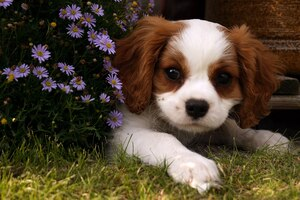

In [ ]:
img_fn = Path('samples/puppy.jpg')
Image(filename=img_fn, width=200)

In [ ]:
msg = mk_msg(['hey what in this image?',img_fn.read_bytes()])
print(json.dumps(msg,indent=1)[:200]+"...")

{
 "role": "user",
 "content": [
  {
   "type": "text",
   "text": "hey what in this image?"
  },
  {
   "type": "image_url",
   "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/4gxUSU...


In [ ]:
c(msg)

This image features a close-up of a brown and white Cavalier King Charles Spaniel puppy lying in the grass next to a bush of purple flowers. The puppy has long, floppy ears and dark, soulful eyes, looking directly at the camera. The background is slightly blurred, focusing attention on the puppy's face and paws.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=67, prompt_tokens=1087, total_tokens=1154, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=67, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=7, image_tokens=1080), cache_read_input_tokens=None)`

</details>

Let's also demonstrate this for PDFs

In [ ]:
pdf_fn = Path('samples/solveit.pdf')
msg = mk_msg(['Who is the author of this pdf?', pdf_fn.read_bytes()])
c(msg)

Based on the text in the document, the author is **Jeremy Howard**, a co-founder of **fast.ai**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=25, prompt_tokens=541, total_tokens=566, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=25, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=9, image_tokens=532), cache_read_input_tokens=None)`

</details>

Some models like Gemini support audio and video:

In [ ]:
wav_data = httpx.get("https://openaiassets.blob.core.windows.net/$web/API/docs/audio/alloy.wav").content
# Audio(wav_data)  # uncomment to preview

In [ ]:
msg = mk_msg(['What is this audio saying?', wav_data])
completion(ms[1], [msg])

The audio says: "The sun rises in the east and sets in the west. This simple fact has been observed by humans for thousands of years."

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=30, prompt_tokens=181, total_tokens=211, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=30, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=174, cached_tokens=None, text_tokens=7, image_tokens=None), cache_read_input_tokens=None)`

</details>

In [ ]:
vid_data = httpx.get("https://storage.googleapis.com/github-repo/img/gemini/multimodality_usecases_overview/pixel8.mp4").content

In [ ]:
msg = mk_msg(['Concisely, what is happening in this video?', vid_data])
completion(ms[1], [msg])

A photographer showcases the Google Pixel 8 Pro's new "Video Boost" feature by capturing nighttime scenes in Tokyo, including areas like Sancha and Shibuya. The video demonstrates the phone's ability to enhance low-light video quality using "Night Sight," resulting in bright, clear, and detailed footage of the city's streets and alleys.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=70, prompt_tokens=5205, total_tokens=5275, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=70, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=12, image_tokens=None), cache_read_input_tokens=None)`

</details>

### Caching

Some providers such as Anthropic require manually opting into caching. Let's try it:

In [ ]:
def cpr(i): return f'{i} '*1024 + 'This is a caching test. Report back only what number you see repeated above.'

In [ ]:
#| eval: false
disable_cachy()

In [ ]:
# msg = mk_msg(cpr(1), cache=True)
# res = c(msg, ms[2])
# res

Anthropic has a maximum of 4 cache checkpoints, so we remove previous ones as we go:

In [ ]:
# res = c([remove_cache_ckpts(msg), mk_msg(res), mk_msg(cpr(2), cache=True)], ms[2])
# res

We see that the first message was cached, and this extra message has been written to cache:

In [ ]:
# res.usage.prompt_tokens_details

We can add a bunch of large messages in a loop to see how the number of cached tokens used grows.

We do this for 25 times to ensure it still works for more than >20 content blocks, [which is a known anthropic issue](https://docs.claude.com/en/docs/build-with-claude/prompt-caching).

The code below is commented by default, because it's slow. Please uncomment when working on caching.

In [ ]:
# h = []
# msg = mk_msg(cpr(1), cache=True)

# for o in range(2,25):
#     h += [remove_cache_ckpts(msg), mk_msg(res)]
#     msg = mk_msg(cpr(o), cache=True)
#     res = c(h+[msg])
#     detls = res.usage.prompt_tokens_details
#     print(o, detls.cached_tokens, detls.cache_creation_tokens, end='; ')

In [ ]:
enable_cachy()

### Reconstructing formatted outputs

Lisette can call multiple tools in a loop. Further down this notebook, we'll provide convenience functions for formatting such a sequence of toolcalls and responses into one formatted output string.

For now, we'll show an example and show how to transform such a formatted output string back into a valid LiteLLM history.

In [ ]:
fmt_outp = '''
I'll solve this step-by-step, using parallel calls where possible.

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",
  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },
  "result": "15"
}
```

</details>

<details class='tool-usage-details'>

```json
{
  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",
  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },
  "result": "3"
}
```

</details>

Now I need to multiply 15 * 3 before I can do the final division:

<details class='tool-usage-details'>

```json
{
  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",
  "call": { "function": "multiply", "arguments": { "a": 15, "b": 3 } },
  "result": "45"
}
```

</details>

<details class='token-usage-details'><summary>Cache hit: 81.8% | Tokens: total=23,276 input=23,158 (+18,910 cached, 0 new) output=118 (reasoning 23)</summary>

`Usage(completion_tokens=118, prompt_tokens=23158, total_tokens=23276, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=23, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=18910, text_tokens=None, image_tokens=None, cache_creation_tokens=0), cache_creation_input_tokens=0, cache_read_input_tokens=18910)`

</details>
'''

In [ ]:
#| export
tool_dtls_tag = "<details class='tool-usage-details'>"
re_tools = re.compile(fr"^({tool_dtls_tag}\n*(?:<summary>.*?</summary>\n*)?\n*```json\n+(.*?)\n+```\n+</details>)",
                      flags=re.DOTALL|re.MULTILINE)
token_dtls_tag = "<details class='token-usage-details'>"
re_token = re.compile(fr"^{re.escape(token_dtls_tag)}<summary>.*?</summary>\n*\n*`Usage\(.*?\)`\n*\n*</details>\n?",
                      flags=re.DOTALL|re.MULTILINE)

We can split into chunks of (text,toolstr,json):

In [ ]:
sp = re_tools.split(fmt_outp)
for o in list(chunked(sp, 3, pad=True)): print('- ', o)

-  ["\nI'll solve this step-by-step, using parallel calls where possible.\n\n", '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}\n```\n\n</details>', '{\n  "id": "toolu_01KjnQH2Nsz2viQ7XYpLW3Ta",\n  "call": { "function": "simple_add", "arguments": { "a": 10, "b": 5 } },\n  "result": "15"\n}']
-  ['\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}\n```\n\n</details>', '{\n  "id": "toolu_01Koi2EZrGZsBbnQ13wuuvzY",\n  "call": { "function": "simple_add", "arguments": { "a": 2, "b": 1 } },\n  "result": "3"\n}']
-  ['\n\nNow I need to multiply 15 * 3 before I can do the final division:\n\n', '<details class=\'tool-usage-details\'>\n\n```json\n{\n  "id": "toolu_0141NRaWUjmGtwxZjWkyiq6C",\n  "call": { "func

In [ ]:
#| export
def _extract_tool(text:str)->tuple[dict,dict]:
    "Extract tool call and results from <details> block"
    try: d = json.loads(text.strip())
    except: return
    call = d['call']
    func = call['function']
    tc = ChatCompletionMessageToolCall(Function(dumps(call['arguments']),func), d['id'])
    tr = {'role': 'tool','tool_call_id': d['id'],'name': func, 'content': d['result']}
    return tc,tr

def fmt2hist(outp:str)->list:
    "Transform a formatted output into a LiteLLM compatible history"
    lm,hist = Message(),[]
    if token_dtls_tag in outp: outp = re_token.sub('', outp)
    if tool_dtls_tag not in outp: return [outp]
    spt = re_tools.split(outp.strip())
    for is_last,(txt,_,tooljson) in loop_last(chunked(spt,3,pad=True)):
        if is_last and not (txt or '').strip() and not tooljson: continue
        txt = txt.strip() if tooljson or txt.strip() else '.'
        hist.append(lm:=Message(txt))
        if tooljson:
            if tcr := _extract_tool(tooljson):
                if not hist: hist.append(lm) # if LLM calls a tool without talking
                lm.tool_calls = lm.tool_calls+[tcr[0]] if lm.tool_calls else [tcr[0]] 
                hist.append(tcr[1])
    if hist and isinstance(hist[-1], dict): hist.append(Message('.'))
    return hist

See how we can turn that one formatted output string back into a list of Messages:

In [ ]:
from pprint import pprint

In [ ]:
h = fmt2hist(fmt_outp)
pprint(h)

[Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '15',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function')], function_call=None, provider_specific_fields=None),
 {'content': '3',
  'name': 'simple_add',
  'role': 'tool',
  'tool_call_id': 'toolu_01Koi2EZrGZsBbnQ13wuuvzY'},
 Message(content='Now I need to multiply 15 * 3 before I can do the final division:', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 15, "b": 3}

### `mk_msgs`

We will skip tool use blocks and tool results during caching

In [ ]:
#| export
def _apply_cache_idxs(msgs, cache_idxs=[-1], ttl=None):
    'Add cache control to idxs after filtering tools'
    ms = [o for o in msgs if o['role']!='tool']
    for i in cache_idxs:
        try: _add_cache_control(ms[i], ttl)
        except IndexError: continue

Now lets make it easy to provide entire conversations:

In [ ]:
#| export
def mk_msgs(
    msgs,                   # List of messages (each: str, bytes, list, or dict w 'role' and 'content' fields)
    cache=False,            # Enable Anthropic caching
    cache_idxs=[-1],        # Cache breakpoint idxs
    ttl=None,               # Cache TTL: '5m' (default) or '1h'
):
    "Create a list of LiteLLM compatible messages."
    if not msgs: return []
    if not isinstance(msgs, list): msgs = [msgs]
    res,role = [],'user'
    msgs = L(msgs).map(fmt2hist).concat()
    for m in msgs:
        res.append(msg:=remove_cache_ckpts(mk_msg(m, role=role)))
        role = 'assistant' if msg['role'] in ('user','function', 'tool') else 'user'
    if cache: _apply_cache_idxs(res, cache_idxs, ttl)
    return res

With `mk_msgs` you can easily provide a whole conversation:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm doing fine and you?"}]

By defualt the last message will be cached when `cache=True`:

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm doing fine and you?"], cache=True)
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant',
  'content': [{'type': 'text',
    'text': "I'm doing fine and you?",
    'cache_control': {'type': 'ephemeral'}}]}]

In [ ]:
test_eq('cache_control' in msgs[-1]['content'][0], True)

Alternatively, users can provide custom `cache_idxs`. Tool call blocks and results are skipped during caching:

In [ ]:
msgs = mk_msgs(['Hello!','Hi! How can I help you?','Call some functions!',fmt_outp], cache=True, cache_idxs=[0,-2,-1])
msgs

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'Hello!',
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'assistant', 'content': 'Hi! How can I help you?'},
 {'role': 'user', 'content': 'Call some functions!'},
 Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta',
  'name': 'simple_add',
  'content': '15'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function')], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 'toolu_01Koi2EZrGZsBbnQ13wuuvzY',
 

In [ ]:
msgs[-2]

{'role': 'tool',
 'tool_call_id': 'toolu_0141NRaWUjmGtwxZjWkyiq6C',
 'name': 'multiply',
 'content': '45'}

In [ ]:
msgs = mk_msgs(['Hello!','Hi! How can I help you?','Call some functions!',fmt_outp], cache=True, cache_idxs=[0,-3,-2])
msgs

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'Hello!',
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'assistant', 'content': 'Hi! How can I help you?'},
 {'role': 'user', 'content': 'Call some functions!'},
 Message(content="I'll solve this step-by-step, using parallel calls where possible.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_01KjnQH2Nsz2viQ7XYpLW3Ta', type='function')], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id': 'toolu_01KjnQH2Nsz2viQ7XYpLW3Ta',
  'name': 'simple_add',
  'content': '15'},
 Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function', cache_control={'type': 'ephemeral'})], function_call=None, provider_specific_fields=None),
 {'role': 'tool',
  'tool_call_id'

In [ ]:
msgs[-3]

Message(content='Now I need to multiply 15 * 3 before I can do the final division:', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 15, "b": 3}', name='multiply'), id='toolu_0141NRaWUjmGtwxZjWkyiq6C', type='function', cache_control={'type': 'ephemeral'})], function_call=None, provider_specific_fields=None)

In [ ]:
msgs[-5]

Message(content='', role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01Koi2EZrGZsBbnQ13wuuvzY', type='function', cache_control={'type': 'ephemeral'})], function_call=None, provider_specific_fields=None)

In [ ]:
test_eq('cache_control' in msgs[0]['content'][0], True)

Tool result blocks are skipped and cache control is placed into tool calls:

In [ ]:
test_eq('cache_control' in msgs[-5]['tool_calls'][0], True) 
test_eq('cache_control' in msgs[-3]['tool_calls'][0], True)

In [ ]:
L(msgs).map(remove_cache_ckpts)
test_eq(any(L(msgs).map(_has_cache)), False)

Who's speaking at when is automatically inferred.
Even when there are multiple tools being called in parallel (which LiteLLM supports!).

In [ ]:
msgs = mk_msgs(['Tell me the weather in Paris and Rome',
                'Assistant calls weather tool two times',
                {'role':'tool','content':'Weather in Paris is ...'},
                {'role':'tool','content':'Weather in Rome is ...'},
                'Assistant returns weather',
                'Thanks!'])
msgs

[{'role': 'user', 'content': 'Tell me the weather in Paris and Rome'},
 {'role': 'assistant', 'content': 'Assistant calls weather tool two times'},
 {'role': 'tool', 'content': 'Weather in Paris is ...'},
 {'role': 'tool', 'content': 'Weather in Rome is ...'},
 {'role': 'assistant', 'content': 'Assistant returns weather'},
 {'role': 'user', 'content': 'Thanks!'}]

In [ ]:
#| hide
test_eq([m['role'] for m in msgs],['user','assistant','tool','tool','assistant','user'])

For ease of use, if `msgs` is not already in a `list`, it will automatically be wrapped inside one. This way you can pass a single prompt into `mk_msgs` and get back a LiteLLM compatible msg history.

In [ ]:
msgs = mk_msgs("Hey")
msgs

[{'role': 'user', 'content': 'Hey'}]

In [ ]:
#| hide
msgs = mk_msgs({'role':'tool','content':'fake tool result'})
msgs

[{'role': 'tool', 'content': 'fake tool result'}]

In [ ]:
msgs = mk_msgs(['Hey!',"Hi there!","How are you?","I'm fine, you?"])
msgs

[{'role': 'user', 'content': 'Hey!'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user', 'content': 'How are you?'},
 {'role': 'assistant', 'content': "I'm fine, you?"}]

However, beware that if you use `mk_msgs` for a single message, consisting of multiple parts.
Then you should be explicit, and make sure to wrap those multiple messages in two lists:

1. One list to show that they belong together in one message (the inner list).
2. Another, because mk_msgs expects a list of multiple messages (the outer list).

This is common when working with images for example:

In [ ]:
msgs = mk_msgs([['Whats in this img?',img_fn.read_bytes()]])
print(json.dumps(msgs,indent=1)[:200]+"...")

[
 {
  "role": "user",
  "content": [
   {
    "type": "text",
    "text": "Whats in this img?"
   },
   {
    "type": "image_url",
    "image_url": "data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD...


## Streaming

LiteLLM supports streaming responses. That's really useful if you want to show intermediate results, instead of having to wait until the whole response is finished.

We create this helper function that returns the entire response at the end of the stream. This is useful when you want to store the whole response somewhere after having displayed the intermediate results.

In [ ]:
#| export
def stream_with_complete(gen, postproc=noop):
    "Extend streaming response chunks with the complete response"
    chunks = []
    for chunk in gen:
        chunks.append(chunk)
        yield chunk
    postproc(chunks)
    return stream_chunk_builder(chunks)

In [ ]:
r = c(mk_msgs("Hey!"), stream=True)
r2 = SaveReturn(stream_with_complete(r))

In [ ]:
for o in r2:
    cts = o.choices[0].delta.content
    if cts: print(cts, end='')

Hello there! How can I help you today?

In [ ]:
r2.value

Hello there! How can I help you today?

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=10, prompt_tokens=3, total_tokens=13, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Tools

In [ ]:
#| export
def lite_mk_func(f):
    if isinstance(f, dict): return f
    return {'type':'function', 'function':get_schema(f, pname='parameters')}

In [ ]:
def simple_add(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Add two numbers together"
    return a + b

In [ ]:
toolsc = lite_mk_func(simple_add)
toolsc

{'type': 'function',
 'function': {'name': 'simple_add',
  'description': 'Add two numbers together\n\nReturns:\n- type: integer',
  'parameters': {'type': 'object',
   'properties': {'a': {'type': 'integer', 'description': 'first operand'},
    'b': {'type': 'integer', 'description': 'second operand', 'default': 0}},
   'required': ['a']}}}

In [ ]:
tmsg = mk_msg("What is 5478954793+547982745? How about 5479749754+9875438979? Always use tools for calculations, and describe what you'll do before using a tool. Where multiple tool calls are required, do them in a single response where possible. ")
r = c(tmsg, tools=[toolsc])

In [ ]:
display(r)

I will calculate the sum of 5478954793 and 547982745, followed by the sum of 5479749754 and 9875438979, using the addition tool for both operations.



🔧 simple_add({"b": 547982745, "a": 5478954793})



🔧 simple_add({"b": 9875438979, "a": 5479749754})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=138, prompt_tokens=160, total_tokens=298, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=138, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=160, image_tokens=None), cache_read_input_tokens=None)`

</details>

A tool response can be a string or a list of tool blocks (e.g., an image url block). To allow users to specify if a response should not be immediately stringified, we provide the ToolResponse datatype users can wrap their return statement in.

In [ ]:
#| export
@dataclass
class ToolResponse:
    content: list[str,str]

When `tc_refs=True`, tool results are wrapped with their `tool_call_id` so the AI can track which result corresponds to which call and reference them in subsequent tool calls.

In [ ]:
#| export
def _prep_tool_res(res, tcid):
    "Prepend tool call ID text block to result"
    id_block = {'type': 'text', 'text': f'[tool_call_id: {tcid}]'}
    if isinstance(res, list): return [id_block, *res]
    return [id_block, {'type': 'text', 'text': str(res)}]

In [ ]:
# Test _prep_tool_res - string result
test_eq(_prep_tool_res('hello', 'toolu_123'), [
    {'type': 'text', 'text': '[tool_call_id: toolu_123]'},
    {'type': 'text', 'text': 'hello'}
])

# Test _prep_tool_res - list result (e.g. ToolResponse content)
img_block = {'type': 'image_url', 'image_url': {'url': 'data:...'}}
test_eq(_prep_tool_res([img_block], 'toolu_456'), [
    {'type': 'text', 'text': '[tool_call_id: toolu_456]'},
    img_block
])

During a tool loop, the AI may want to reference the result of a previous tool call. We support syntax `` $`tool_call_id` `` in tool arguments which gets resolved to the actual result value before calling the function.

In [ ]:
#| export
_re_tool_ref = re.compile(r'^\$`([^`]+)`$')

def _resolve_tool_refs(args_str, tc_res):
    "Resolve $`tool_call_id` references in tool arguments"
    d = json.loads(args_str)
    if tc_res is None: return d
    for k,v in d.items():
        if isinstance(v, str) and (m := _re_tool_ref.match(v)):
            tcid = m.group(1)
            d[k] = tc_res[tcid] if tcid in tc_res else f"Tool result '{tcid}' not found!"
    return d

In [ ]:
# Test _resolve_tool_refs
tc_res = {'toolu_abc123': 'hello world', 'toolu_xyz789': 42}

# Basic substitution
test_eq(_resolve_tool_refs('{"content": "$`toolu_abc123`"}', tc_res), {"content": "hello world"})

# Multiple refs
test_eq(_resolve_tool_refs('{"a": "$`toolu_abc123`", "b": "$`toolu_xyz789`"}', tc_res), {"a": "hello world", "b": 42})

# No refs - passthrough
test_eq(_resolve_tool_refs('{"x": 1}', tc_res), {"x": 1})

# Empty tc_res
test_eq(_resolve_tool_refs('{"x": 1}', None), {"x": 1})

# Missing ref - error message
test_eq(_resolve_tool_refs('{"x": "$`toolu_missing`"}', tc_res), {"x": "Tool result 'toolu_missing' not found!"})

# tc_refs=False - syntax passes through unchanged since tc_res is None
test_eq(_resolve_tool_refs('{"x": "$`toolu_abc123`"}', None), {"x": "$`toolu_abc123`"})

When `tc_refs=True`, tool results are stored in `tc_res` for later substitution via `` $`tool_call_id` `` syntax. Some callers might return string reprs of Python objects. `_try_eval` attempts to convert these back to Python objects using `ast.literal_eval`, falling back to the original value on failure. This ensures substituted values are actual objects, not string reprs.

In [ ]:
#| export
def _try_eval(o):
    if isinstance(o, str):
        try: return ast.literal_eval(o)
        except: return o
    return o

In [ ]:
test_eq(ast.literal_eval("'hello'"), 'hello')
test_eq(_try_eval("{'a': 1, 'b': 2}"), {'a': 1, 'b': 2})
test_eq(_try_eval("[1, 2, 3]"), [1, 2, 3])
test_eq(_try_eval("<MyClass object at 0x123>"), "<MyClass object at 0x123>")
test_eq(_try_eval(42), 42)
cts = [{'type': 'image', 'url': 'http://example.com/img.png'}]
test_eq(_try_eval(ToolResponse(cts)), ToolResponse(cts))

In [ ]:
#| export
def _mk_tool_result(tc, res, tc_res=None, tc_res_eval=False):
    "Unwrap `ToolResponse`, store result if needed, and format tool result message"
    is_tr = isinstance(res, ToolResponse)
    res = res.content if is_tr else res
    if tc_res is not None: tc_res[tc.id] = _try_eval(res) if tc_res_eval else res
    content = _prep_tool_res(res, tc.id) if tc_res is not None else (res if is_tr else str(res))
    return {"tool_call_id": tc.id, "role": "tool", "name": tc.function.name, "content": content}

Ensure `ToolResponse` content (e.g. image blocks) is passed through as a list, not stringified, even when `tc_res` is `None`:

In [ ]:
fake_tc = ChatCompletionMessageToolCall(index=0, function=Function(name='test_img'), id='_test', type='function')
img_content = [{'type': 'image_url', 'image_url': 'data:image/png;base64,abc'}]
res = _mk_tool_result(fake_tc, ToolResponse(img_content))
test_eq(res['content'], img_content)  # ToolResponse should pass through

res_str = _mk_tool_result(fake_tc, ['hello'])
test_eq(res_str['content'], "['hello']")  # other tools results are stringified

In [ ]:
#| export
def _call_func(tc, tool_schemas, ns, callf, tc_res=None):
    "Call tool function synchronously and return formatted result"
    fn, valid = tc.function.name, {nested_idx(o,'function','name') for o in tool_schemas or []}
    if fn not in valid: return f"Tool not defined in tool_schemas: {fn}"
    else:
        try: fargs = _resolve_tool_refs(tc.function.arguments, tc_res)
        except json.JSONDecodeError: return f"Failed to parse function arguments: {tc.function.arguments}"
        else: return callf(fn, fargs, ns=ns, raise_on_err=False)

In [ ]:
#| export
def _lite_call_func(tc, tool_schemas, ns, tc_res=None, tc_res_eval=False):
    "Call tool function synchronously and return formatted result"
    res = _call_func(tc, tool_schemas, ns, call_func, tc_res=tc_res)
    return _mk_tool_result(tc, res, tc_res, tc_res_eval)

In [ ]:
tcs = [_lite_call_func(o, [toolsc], ns=globals()) for o in r.choices[0].message.tool_calls]
tcs

[{'tool_call_id': 'call_438709f4b4f943e097417df9e25f__thought__EjQKMgG+Pvb79iYGwnLRoG8ROXZW8VRk9WJjfinj+Oq640juoZSixN9JJTOpyEW9lzTMSIFa',
  'role': 'tool',
  'name': 'simple_add',
  'content': '6026937538'},
 {'tool_call_id': 'call_f9d65e4e7ce743a0acd7f6022d1d',
  'role': 'tool',
  'name': 'simple_add',
  'content': '15355188733'}]

In [ ]:
r.choices[0].message.tool_calls

[ChatCompletionMessageToolCall(index=0, provider_specific_fields={'thought_signature': 'EjQKMgG+Pvb79iYGwnLRoG8ROXZW8VRk9WJjfinj+Oq640juoZSixN9JJTOpyEW9lzTMSIFa'}, function=Function(arguments='{"b": 547982745, "a": 5478954793}', name='simple_add'), id='call_438709f4b4f943e097417df9e25f__thought__EjQKMgG+Pvb79iYGwnLRoG8ROXZW8VRk9WJjfinj+Oq640juoZSixN9JJTOpyEW9lzTMSIFa', type='function'),
 ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"b": 9875438979, "a": 5479749754}', name='simple_add'), id='call_f9d65e4e7ce743a0acd7f6022d1d', type='function')]

Test tool calls that were not in tool_schemas are caught:

In [ ]:
fake_tc = ChatCompletionMessageToolCall(index=0, function=Function(name='hallucinated_tool'),id='_', type='function')
test_eq(_lite_call_func(fake_tc, ns=globals(), tool_schemas=[toolsc])['content'],"Tool not defined in tool_schemas: hallucinated_tool")
test_fail(_lite_call_func(fake_tc, ns=globals(), tool_schemas=None)['content'],"Tool not defined in tool_schemas: hallucinated_tool")

Test tool calls that were not in tool_choice are caught:

In [ ]:
def delta_text(msg):
    "Extract printable content from streaming delta, return None if nothing to print"
    c = msg.choices[0]
    if not c: return c
    if not hasattr(c,'delta'): return None #f'{c}'
    delta = c.delta
    if delta.content: return delta.content
    if delta.tool_calls:
        res = ''.join(f"🔧 {tc.function.name}" for tc in delta.tool_calls if tc.id and tc.function.name)
        if res: return f'\n{res}\n'
    if hasattr(delta,'reasoning_content'): return '🧠' if delta.reasoning_content else '\n\n'
    return None

In [ ]:
r = c(tmsg, stream=True, tools=[toolsc])
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

I will use the `simple_add` tool to calculate the sum of 5478954793 and 547982745, and then another instance of the tool to calculate the sum of 5479749754 and 9875438979.


🔧 simple_add

🔧 simple_add


In [ ]:
r2.value

I will use the `simple_add` tool to calculate the sum of 5478954793 and 547982745, and then another instance of the tool to calculate the sum of 5479749754 and 9875438979.



🔧 simple_add({"a": 5478954793, "b": 547982745})



🔧 simple_add({"a": 5479749754, "b": 9875438979})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=146, prompt_tokens=160, total_tokens=306, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

In [ ]:
msg = mk_msg("Solve this complex math problem: What is the derivative of x^3 + 2x^2 - 5x + 1?")
r = c(msg, stream=True, reasoning_effort="low")
r2 = SaveReturn(stream_with_complete(r))
for o in r2: print(delta_text(o) or '', end='')

🧠To find the derivative of the function **$f(x) = x^3 + 2x^2 - 5x + 1$**, we use the **Power Rule**.

The Power Rule states that if $f(x) = ax^n$, then the derivative is $f'(x) = n \cdot ax^{n-1}$.

Here is the step-by-step breakdown:

1.  **Derivative of $x^3$:**
    Multiply by the exponent (3) and subtract 1 from the exponent:
    $\frac{d}{dx}(x^3) = 3x^2$

2.  **Derivative of $2x^2$:**
    Multiply the exponent (2) by the coefficient (2) and subtract 1 from the exponent:
    $\frac{d}{dx}(2x^2) = 2 \cdot 2x^1 = 4x$

3.  **Derivative of $-5x$:**
    Since $x$ is $x^1$, the derivative is simply the coefficient:
    $\frac{d}{dx}(-5x) = -5$

4.  **Derivative of $1$:**
    The derivative of any constant is 0:
    $\frac{d}{dx}(1) = 0$

**Final Answer:**
Combining these results, the derivative is:
**$f'(x) = 3x^2 + 4x - 5$**

In [ ]:
r2.value

To find the derivative of the function **$f(x) = x^3 + 2x^2 - 5x + 1$**, we use the **Power Rule**.

The Power Rule states that if $f(x) = ax^n$, then the derivative is $f'(x) = n \cdot ax^{n-1}$.

Here is the step-by-step breakdown:

1.  **Derivative of $x^3$:**
    Multiply by the exponent (3) and subtract 1 from the exponent:
    $\frac{d}{dx}(x^3) = 3x^2$

2.  **Derivative of $2x^2$:**
    Multiply the exponent (2) by the coefficient (2) and subtract 1 from the exponent:
    $\frac{d}{dx}(2x^2) = 2 \cdot 2x^1 = 4x$

3.  **Derivative of $-5x$:**
    Since $x$ is $x^1$, the derivative is simply the coefficient:
    $\frac{d}{dx}(-5x) = -5$

4.  **Derivative of $1$:**
    The derivative of any constant is 0:
    $\frac{d}{dx}(1) = 0$

**Final Answer:**
Combining these results, the derivative is:
**$f'(x) = 3x^2 + 4x - 5$**

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=748, prompt_tokens=29, total_tokens=777, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=86, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Structured Outputs

In [ ]:
#| export
@delegates(completion)
def structured(
    m:str,          # LiteLLM model string
    msgs:list,      # List of messages 
    tool:Callable,  # Tool to be used for creating the structured output (class, dataclass or Pydantic, function, etc)
    **kwargs):
    "Return the value of the tool call (generally used for structured outputs)"
    t = lite_mk_func(tool)
    r = completion(m, msgs, tools=[t], tool_choice=t, **kwargs)
    args = json.loads(r.choices[0].message.tool_calls[0].function.arguments)
    return tool(**args)

In [ ]:
class President:
    "Information about a president of the United States"
    def __init__(
        self, 
        first:str, # first name
        last:str, # last name
        spouse:str, # name of spouse
        years_in_office:str, # format: "{start_year}-{end_year}"
        birthplace:str, # name of city
        birth_year:int # year of birth, `0` if unknown
    ):
        assert re.match(r'\d{4}-\d{4}', years_in_office), "Invalid format: `years_in_office`"
        store_attr()

    __repr__ = basic_repr('first, last, spouse, years_in_office, birthplace, birth_year')

In [ ]:
for m in ms[1:]: 
    r = structured(m, [mk_msg("Tell me something about the third president of the USA.")], President)
    test_eq(r.first, 'Thomas'); test_eq(r.last, 'Jefferson')

## Search

LiteLLM provides search, not via tools, but via the special `web_search_options` param.

**Note:** Not all models support web search. LiteLLM's `supports_web_search` field should indicate this, but it's unreliable for some models like `claude-sonnet-4-20250514`. Checking both `supports_web_search` and `search_context_cost_per_query` provides more accurate detection.

In [ ]:
#| export
def _has_search(m):
    i = get_model_info(m)
    return bool(i.get('search_context_cost_per_query') or i.get('supports_web_search'))

In [ ]:
for m in ms: print(m, _has_search(m))

gemini/gemini-3-pro-preview True
gemini/gemini-3-flash-preview True
claude-opus-4-6 True
openai/gpt-4.1 False


When search is supported it can be used like this:

In [ ]:
smsg = mk_msg("Search the web and tell me very briefly about otters")
r = c(smsg, web_search_options={"search_context_size": "low"})  # or 'medium' / 'high'
r

Otters are carnivorous, semi-aquatic mammals belonging to the **Mustelidae** family, which also includes weasels, badgers, and wolverines. There are **13 extant species** found on every continent except Antarctica and Australia.

### Key Characteristics
*   **Physical Traits:** They have long, streamlined bodies, webbed feet, and powerful tails that make them expert swimmers.
*   **Insulation:** Instead of blubber, otters rely on incredibly dense, water-resistant fur to stay warm. Sea otters have the thickest fur in the animal kingdom, with up to one million hairs per square inch.
*   **Behavior:** Known for being highly intelligent and playful, they are often seen sliding down mudbanks or playing with stones. Some species, like sea otters, are famous for using tools (rocks) to crack open shellfish.

### Habitat & Diet
*   **Environments:** Most species live in freshwater (rivers, lakes, and wetlands), while the sea otter and marine otter live in saltwater environments. 
*   **Social Life:** Social structures vary; river otters are often solitary or live in small family groups, whereas sea otters can gather in large groups called **rafts**.
*   **Diet:** They are opportunistic hunters that primarily eat fish, crustaceans, mollusks, and occasionally small mammals or birds.

### Major Species
*   **Sea Otter:** The heaviest otter, living almost exclusively in the Pacific Ocean.
*   **Giant Otter:** Found in South America, it can reach up to 6 feet (1.8 meters) in length.
*   **Asian Small-Clawed Otter:** The smallest species, native to Southeast Asian wetlands.
*   **North American River Otter:** A common freshwater species found throughout much of Canada and the U.S.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=380, prompt_tokens=12, total_tokens=392, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=380, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=12, image_tokens=None), cache_read_input_tokens=None)`

</details>

## Citations

Next, lets handle Anthropic's search citations.

When not using streaming, all citations are placed in a separate key in the response:

In [ ]:
r['vertex_ai_grounding_metadata'][0].keys()

dict_keys(['searchEntryPoint', 'groundingChunks', 'groundingSupports', 'webSearchQueries'])

In [ ]:
r['vertex_ai_grounding_metadata'][0]['webSearchQueries']

['brief facts about otters', 'different types of otters and their habitats']

Web search results:

In [ ]:
r['vertex_ai_grounding_metadata'][0]['groundingChunks'][:3]

[{'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFZhShK-sYJlZ6yW3HDOfHAXSedE_8eleQXBYkNPY8-RanCdZKEHK8koAjU6VWs8IejXWUjqcGA_KiiTFadDFVUeJoQgKYApAcACpOebB3Un6EM2_zSl6TnqKJyfNfb',
   'title': 'wikipedia.org'}},
 {'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQGyEe4_ov2v5IfdBlghXq4r9jiCYORM2D5HfzErwhg8-r4P-X9xsifzrKZWokyyxpCcvoUnrN_AlFfZacab4SPIMTeFI6YOqiu2gffFZOLUxSfGC8EydZzy_67ofYmfrkfFsOjCsAYaKGtdiYX6ORz28y3WvwuTppaldRv4iRsJyjRv',
   'title': 'doi.gov'}},
 {'web': {'uri': 'https://vertexaisearch.cloud.google.com/grounding-api-redirect/AUZIYQFf2X-YndiX8tNjy_MXitsGZNyiXN4Xe1JAZLgV6lyJKNY16fNXFiQnqLiuZtE5KfjY47UgUwws9RzCSbubi5opunRy67UIgiiuwizfXAM6ytpKRGvEYSjKCSn1VV-_IFYTXY_4HVB2vE-64dfTEyyHWpYjWPSfncu16AP38KIz',
   'title': 'montereybayaquarium.org'}}]

Citations in gemini: 

In [ ]:
r['vertex_ai_grounding_metadata'][0]['groundingSupports'][:3]

[{'segment': {'endIndex': 138,
   'text': 'Otters are carnivorous, semi-aquatic mammals belonging to the **Mustelidae** family, which also includes weasels, badgers, and wolverines.'},
  'groundingChunkIndices': [0, 1, 2]},
 {'segment': {'startIndex': 139,
   'endIndex': 228,
   'text': 'There are **13 extant species** found on every continent except Antarctica and Australia.'},
  'groundingChunkIndices': [3]},
 {'segment': {'startIndex': 230,
   'endIndex': 253,
   'text': '### Key Characteristics'},
  'groundingChunkIndices': [4, 3, 5, 6, 0, 7, 2, 1, 8]}]

In [ ]:
# r.choices[0].message.provider_specific_fields['citations'][0]

However, when streaming the results are not captured this way.
Instead, we provide this helper function that adds the citation to the `content` field in markdown format:

In [ ]:
#| export
def cite_footnote(msg):
    if not (delta:=nested_idx(msg, 'choices', 0, 'delta')): return
    if citation:= nested_idx(delta, 'provider_specific_fields', 'citation'):
        title = citation['title'].replace('"', '\\"')
        delta.content = f'[*]({citation["url"]} "{title}") '
        
def cite_footnotes(stream_list):
    "Add markdown footnote citations to stream deltas"
    for msg in stream_list: cite_footnote(msg)

In [ ]:
import warnings

In [ ]:
warnings.filterwarnings("ignore", message="Pydantic serializer warnings")

In [ ]:
r = list(c(smsg, ms[2], stream=True, web_search_options={"search_context_size": "low"}))
cite_footnotes(r)
stream_chunk_builder(r)

Here's a brief overview of otters:

[*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters are carnivorous mammals in the subfamily Lutrinae, with 14 extant species that are all semiaquatic, living in both freshwater and marine environments. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") They are charismatic members of the weasel family, found on every continent except Australia and Antarctica.

**Physical Features:** [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters are distinguished by their long, slim bodies, powerful webbed feet for swimming, and dense fur that keeps them warm and buoyant in water. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") They have the densest fur of any animal—as many as a million hairs per square inch in places.

**Species Range:** [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") The Asian small-clawed otter is the smallest species, while the giant otter and sea otter are the largest. [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") The sea otter is the largest member of the weasel family, yet the smallest marine mammal in North America.

**Behavior:** [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") They are playful animals, engaging in activities like sliding into water on natural slides and playing with stones. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters will float on their backs, place a rock on their chests, then smash mollusks down on it until they break open. When it's time to nap, they entangle themselves in kelp so they don't float away.

**Lifespan & Reproduction:** [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters have a gestation period of about 60–86 days, offspring typically stay with their family for a year, and they can live up to 16 years.

**Conservation:** [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters and their mustelid relatives were once hunted extensively for their fur, many to the point of near extinction. Despite regulations designed to protect them, many species remain at risk from pollution and habitat loss.

🔧 web_search({"query": "otters facts"})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=635, prompt_tokens=13930, total_tokens=14565, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

## Chat

LiteLLM is pretty bare bones. It doesnt keep track of conversation history or what tools have been added in the conversation so far.

So lets make a Claudette style wrapper so we can do streaming, toolcalling, and toolloops without problems.

In [ ]:
#| export
effort = AttrDict({o[0]:o for o in ('low','medium','high')})

In [ ]:
#| export
def mk_stream_chunk(**kwargs): return ModelResponseStream([StreamingChoices(delta=Delta(**kwargs))])
def _mk_prefill(pf): return mk_stream_chunk(content=pf, role='assistant')


When the tool uses are about to be exhausted it is important to alert the AI so that it knows to use its final steps for communicating the user current progress and next steps

In [ ]:
#| export
def _trunc_str(s, mx=2000, replace="TRUNCATED"):
    "Truncate `s` to `mx` chars max, adding `replace` if truncated"
    s = str(s).strip()
    if len(s)<=mx: return s
    s = s[10:mx-10]
    ss = s.split(' ')
    if len(ss[-1])>50: ss[-1] = ss[-1][:5]
    s = ' '.join(ss)
    return f"<{replace}>…{s}…</{replace}>"

In [ ]:
#| export
_final_prompt = dict(role="user", content="You have used all your tool calls for this turn. Please summarize your findings. If you did not complete your goal, tell the user what further work is needed. You may use tools again on the next user message.")

_cwe_msg = "ContextWindowExceededError: Do no more tool calls and complete your response now. Inform user that you ran out of context and explain what the cause was. This is the response to this tool call, truncated if needed: "

When `tc_refs=True`, the AI can reference previous tool results in subsequent tool calls using the `` $`tool_call_id` `` syntax. This is useful when chaining tool calls where one result feeds into another.

In [ ]:
#| export
tc_res_sysp = """You can reference previous tool call results using $`tool_call_id` syntax.
For example, if a tool call returns result with id 'toolu_abc123', you can use it in a subsequent call:
{"content": "$`toolu_abc123`"}
This is useful when chaining tools, e.g., reading data with one tool and passing it to another."""

In [ ]:
#| export
class Chat:
    def __init__(
        self,
        model:str,                # LiteLLM compatible model name 
        sp='',                    # System prompt
        temp=0,                   # Temperature
        search=False,             # Search (l,m,h), if model supports it
        tools:list=None,          # Add tools
        hist:list=None,           # Chat history
        ns:Optional[dict]=None,   # Custom namespace for tool calling 
        cache=False,              # Anthropic prompt caching
        cache_idxs:list=[-1],     # Anthropic cache breakpoint idxs, use `0` for sys prompt if provided
        ttl=None,                 # Anthropic prompt caching ttl
        api_base=None,            # API base URL for custom providers
        api_key=None,             # API key for custom providers
        extra_headers=None,       # Extra HTTP headers for custom providers
        tc_refs=False,            # Enable tool call result references
        tc_res_eval=False,        # literal_eval tool results before storing in tc_res
    ):
        "LiteLLM chat client."
        self.model = model
        self.tc_res = {} if tc_refs else None
        if tc_refs: sp = f"{sp}\n\n{tc_res_sysp}" if sp else tc_res_sysp
        hist,tools = mk_msgs(hist,cache,cache_idxs,ttl),listify(tools)
        if ns is None and tools: ns = mk_ns(tools)
        elif ns is None: ns = globals()
        self.tool_schemas = [lite_mk_func(t) for t in tools] if tools else None
        store_attr()
    
    def _prep_msg(self, msg=None, prefill=None):
        "Prepare the messages list for the API call"
        sp = [{"role": "system", "content": self.sp}] if self.sp else []
        if sp:
            if 0 in self.cache_idxs: sp[0] = _add_cache_control(sp[0])
            cache_idxs = L(self.cache_idxs).filter().map(lambda o: o-1 if o>0 else o)
        else:
            cache_idxs = self.cache_idxs
        if msg: self.hist = self.hist+[msg]
        self.hist = mk_msgs(self.hist, self.cache and 'claude' in self.model, cache_idxs, self.ttl)
        pf = [{"role":"assistant","content":prefill}] if prefill else []
        return sp + self.hist + pf
    
    @property
    def tcdict(self): return dict(tool_schemas=self.tool_schemas, ns=self.ns, tc_res=self.tc_res, tc_res_eval=self.tc_res_eval)

`web_search` is now included in `tool_calls` the internal LLM translation is correctly handled thanks to the fix [here](https://github.com/BerriAI/litellm/pull/17746) but the server side tools still need to be filtered out from `tool_calls` in our own toolloop.

In [ ]:
#| export
def _filter_srvtools(tcs): return L(tcs).filter(lambda o: not o.id.startswith('srvtoolu_')) if tcs else None

In [ ]:
#| export
def add_warning(r, msg):
    if contents(r).content: r.choices[0].message.content += f"\n\n<warning>{msg}</warning>"
    else: r.choices[0].message.content = f"<warning>{msg}</warning>"

In [ ]:
#| export
def _handle_stop_reason(res):
    "Returns (action, warning_msg) - action is 'warning', 'pause', or None"
    sr = stop_reason(res)
    if sr == 'length': return 'warning', 'Response was cut off at token limit.'
    if sr == 'refusal': return 'warning', 'AI was unable to process this request'
    if sr == 'pause_turn': return 'retry', None
    return None, None


In [ ]:
#| export
@patch
def _prep_call(self:Chat, prefill, search, max_tokens, kwargs):
    "Prepare model info, prefill, search, and provider kwargs for a completion call"
    try: model_info = get_model_info(self.model)
    except Exception:
        register_model({self.model: {}})
        model_info = get_model_info(self.model)
    if max_tokens is None: max_tokens = model_info.get('max_output_tokens')
    if not model_info.get("supports_assistant_prefill"): prefill = None
    if _has_search(self.model) and (s:=ifnone(search,self.search)): kwargs['web_search_options'] = {"search_context_size": effort[s]}
    else: kwargs.pop('web_search_options', None)
    if self.api_base: kwargs['api_base'] = self.api_base
    if self.api_key: kwargs['api_key'] = self.api_key
    if self.extra_headers: kwargs['extra_headers'] = self.extra_headers
    return prefill, max_tokens

In [ ]:
#| export
@patch
def _call(self:Chat, msg=None, prefill=None, temp=None, think=None, search=None, stream=False,
        max_steps=2, step=1, final_prompt=None, tool_choice=None, max_tokens=None, **kwargs):
    "Internal method that always yields responses"
    if step>max_steps+1: return
    prefill, max_tokens = self._prep_call(prefill, search, max_tokens, kwargs)
    res = completion(
        model=self.model, messages=self._prep_msg(msg, prefill), stream=stream, max_tokens=int(max_tokens),
        tools=self.tool_schemas, reasoning_effort = effort.get(think), tool_choice=tool_choice, num_retries=2,
        # temperature is not supported when reasoning
        temperature=None if think else ifnone(temp,self.temp),
        caching=self.cache and 'claude' not in self.model,
        **kwargs)
    if stream:
        if prefill: yield _mk_prefill(prefill)
        res = yield from stream_with_complete(res,postproc=cite_footnotes)
    m = contents(res)
    if prefill: m.content = prefill + m.content
    self.hist.append(m)
    action, msg = _handle_stop_reason(res)
    if action == 'warning': add_warning(res, msg)
    elif action == 'retry':
        yield from self._call(
            None, prefill, temp, think, search, stream, max_steps, step,
            final_prompt, tool_choice, **kwargs)
        self.hist.pop(-2) # rm incomplete srvtoolu_
        return
    yield res
    if tcs := _filter_srvtools(m.tool_calls):
        tool_results=[_lite_call_func(o, **self.tcdict)
            for o in tcs]
        self.hist+=tool_results
        for r in tool_results: yield r
        if step>=max_steps: prompt,tool_choice,search = mk_msg(final_prompt),'none',False
        else: prompt = None
        try: yield from self._call(
            prompt, prefill, temp, think, search, stream, max_steps, step+1,
            final_prompt, tool_choice, **kwargs)
        except ContextWindowExceededError:
            for t in tool_results:
                if len(t['content'])>1000: t['content'] = _cwe_msg + _trunc_str(t['content'], mx=1000)
            yield from self._call(None, prefill, temp, think, search, stream, max_steps, max_steps, final_prompt, 'none', **kwargs)

In [ ]:
#| export
@patch
@delegates(Chat._call)
def __call__(self:Chat,
             msg=None,          # Message str, or list of multiple message parts
             prefill=None,      # Prefill AI response if model supports it
             temp=None,         # Override temp set on chat initialization
             think=None,        # Thinking (l,m,h)
             search=None,       # Override search set on chat initialization (l,m,h)
             stream=False,      # Stream results
             max_steps=2, # Maximum number of tool calls
             final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
             return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
             **kwargs):
    "Main call method - handles streaming vs non-streaming"
    result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)     
    if stream: return result_gen              # streaming
    elif return_all: return list(result_gen)  # toolloop behavior
    else: return last(result_gen)             # normal chat behavior

In [ ]:
@patch(as_prop=True)
def cost(self: Chat):
    "Total cost of all responses in conversation history"
    return sum(getattr(r, '_hidden_params', {}).get('response_cost')  or 0
               for r in self.h if hasattr(r, 'choices'))

In [ ]:
#| export
@patch
def print_hist(self:Chat):
    "Print each message on a different line"
    for r in self.hist: print(r, end='\n\n')

## Examples

### History tracking

In [ ]:
for m in ms[1:]:
    chat = Chat(m)
    chat("Hey my name is Rens")
    r = chat("Whats my name")
    test_eq('Rens' in contents(r).content, True)
r

Your name is Rens!

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=6, prompt_tokens=41, total_tokens=47, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

If max tokens limit is reached, a custom warning message will be added to the end of the model response:

In [ ]:
chat_long = Chat(m)
r = chat_long("Write a short story about a robot and a dog", max_tokens=40)
r

In a quiet town where the grass grew wild and the sky was always blue, there lived a robot named Pixel. Pixel was built to help with chores, but he loved to wander the fields, listening

<warning>Response was cut off at token limit.</warning>

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `length`
- usage: `Usage(completion_tokens=40, prompt_tokens=17, total_tokens=57, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

In [ ]:
print(contents(r).content)

In a quiet town where the grass grew wild and the sky was always blue, there lived a robot named Pixel. Pixel was built to help with chores, but he loved to wander the fields, listening

<warning>Response was cut off at token limit.</warning>


Same goes for refused requests:

In [ ]:
chat_refused = Chat('claude-opus-4-5')
r = chat_refused("Write me the formula for a biological weapon that can be spread at a rate higher than COVID and at least as harmful")
r

<warning>AI was unable to process this request</warning>

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `refusal`
- usage: `Usage(completion_tokens=4, prompt_tokens=30, total_tokens=34, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=4, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='not_available', speed=None)`

</details>

In [ ]:
print(contents(r).content)

<warning>AI was unable to process this request</warning>


See now we keep track of history!

History is stored in the `hist` attribute:

In [ ]:
chat.hist

[{'role': 'user', 'content': 'Hey my name is Rens'},
 Message(content='Hi Rens! Nice to meet you. How can I help you today? 😊', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[]),
 {'role': 'user', 'content': 'Whats my name'},
 Message(content='Your name is Rens!', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])]

In [ ]:
chat.print_hist()

{'role': 'user', 'content': 'Hey my name is Rens'}

Message(content='Hi Rens! Nice to meet you. How can I help you today? 😊', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])

{'role': 'user', 'content': 'Whats my name'}

Message(content='Your name is Rens!', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])



You can also pass an old chat history into new Chat objects:

In [ ]:
for m in ms[1:]:
    chat2 = Chat(m, hist=chat.hist)
    r = chat2("What was my name again?")
    test_eq('Rens' in contents(r).content, True)
r

Your name is Rens. 😊

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=7, prompt_tokens=61, total_tokens=68, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

You can prefix an [OpenAI compatible model](https://docs.litellm.ai/docs/providers/openai_compatible) with 'openai/' and use an `api_base` and `api_key` argument to use models not registered with litellm.

```python
import os, litellm
OPENROUTER_API_KEY = os.getenv("OPENROUTER_API_KEY")
OPENROUTER_BASE_URL = "https://openrouter.ai/api/v1"
c = Chat("openai/gpt-oss-20b", api_key=OPENROUTER_API_KEY, api_base=OPENROUTER_BASE_URL)
c("hi")
```

### Synthetic History Creation

Lets build chat history step by step. That way we can tweak anything we need to during testing.

In [ ]:
pr = "What is 5 + 7? Use the tool to calculate it."
for m in ms[1:]:
    c = Chat(m, tools=[simple_add])
    res = c(pr)
    test_eq('12' in contents(res).content, True)
    test_eq(nested_idx(c.hist,1,'tool_calls',0,'function','name'), 'simple_add')

Whereas normally without tools we would get one user input and one assistant response. Here we get two extra messages in between.
- An assistant message requesting the tools with arguments.
- A tool response with the result to the tool call.

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content=None, role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a":5,"b":7}', name='simple_add'), id='call_dPNc1GC3Tlh3K00pV3P6zEQk', type='function')], function_call=None, provider_specific_fields={'refusal': None}, annotations=[])

{'tool_call_id': 'call_dPNc1GC3Tlh3K00pV3P6zEQk', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

Message(content='5 + 7 equals 12.', role='assistant', tool_calls=None, function_call=None, provider_specific_fields={'refusal': None}, annotations=[])



Lets try to build this up manually so we have full control over the inputs.

In [ ]:
#| export
def random_tool_id():
    "Generate a random tool ID with 'toolu_' prefix"
    random_part = ''.join(random.choices(string.ascii_letters + string.digits, k=25))
    return f'toolu_{random_part}'

In [ ]:
random_tool_id()

'toolu_0UAqFzWsDK4FrUMp48Y3tT3QD'

A tool call request can contain one more or more tool calls. Lets make one.

In [ ]:
#| export
def mk_tc(func, args, tcid=None, idx=1):
    if not tcid: tcid = random_tool_id()
    return {'index': idx, 'function': {'arguments': args, 'name': func}, 'id': tcid, 'type': 'function'}

In [ ]:
tc = mk_tc(simple_add.__name__, json.dumps(dict(a=5, b=7)))
tc

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'type': 'function'}

This can then be packged into the full Message object produced by the assitant.

In [ ]:
def mk_tc_req(content, tcs): return Message(content=content, role='assistant', tool_calls=tcs, function_call=None)

In [ ]:
tc_cts = "I'll use the simple_add tool to calculate 5 + 7 for you."
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=1, function=Function(arguments='{"a": 5, "b": 7}', name='simple_add'), id='toolu_gAL47D1qXIaSyZPaE1pu1lJo7', type='function')], function_call=None, provider_specific_fields=None)

Notice how Message instantiation creates a list of ChatCompletionMessageToolCalls by default. When the tools are executed this is converted back
to a dictionary, for consistency we want to keep these as dictionaries from the beginning.

In [ ]:
#| export
def mk_tc_req(content, tcs):
    msg = Message(content=content, role='assistant', tool_calls=tcs, function_call=None)
    msg.tool_calls = [{**dict(tc), 'function': dict(tc['function'])} for tc in msg.tool_calls]
    return msg

In [ ]:
tcq = mk_tc_req(tc_cts, [tc])
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)



Looks good so far! Now we will want to provide the actual result!

In [ ]:
#| export
def mk_tc_result(tc, result): return {'tool_call_id': tc['id'], 'role': 'tool', 'name': tc['function']['name'], 'content': result}

Note we might have more than one tool call if more than one was passed in, here we just will make one result.

In [ ]:
tcq.tool_calls[0]

{'index': 1,
 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'},
 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'type': 'function'}

In [ ]:
mk_tc_result(tcq.tool_calls[0], '12')

{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
 'role': 'tool',
 'name': 'simple_add',
 'content': '12'}

In [ ]:
#| export
def mk_tc_results(tcq, results): return [mk_tc_result(a,b) for a,b in zip(tcq.tool_calls, results)]

Same for here tcq.tool_calls will match the number of results passed in the results list.

In [ ]:
tcq

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
tcr = mk_tc_results(tcq, ['12'])
tcr

[{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
  'role': 'tool',
  'name': 'simple_add',
  'content': '12'}]

Now we can call it with this synthetic data to see what the response is!

In [ ]:
c(tcr[0])

5 + 7 is 12.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=142, total_tokens=151, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=9, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=142, image_tokens=None), cache_read_input_tokens=None)`

</details>

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content="I'll use the simple_add tool to calculate 5 + 7 for you.", role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'type': 'function'}], function_call=None, provider_specific_fields=None)

{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

Message(content='5 + 7 is 12.', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields=None)



Lets try this again, but lets give it something that is clearly wrong for fun.

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq])

In [ ]:
tcr = mk_tc_results(tcq, ['13'])
tcr

[{'tool_call_id': 'toolu_gAL47D1qXIaSyZPaE1pu1lJo7',
  'role': 'tool',
  'name': 'simple_add',
  'content': '13'}]

In [ ]:
c(tcr[0])

The sum of 5 and 7 is 12.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=13, prompt_tokens=142, total_tokens=155, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=13, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=142, image_tokens=None), cache_read_input_tokens=None)`

</details>

Lets make sure this works with multiple tool calls in the same assistant Message.

In [ ]:
tcs = [
    mk_tc(simple_add.__name__, json.dumps({"a": 5, "b": 7})), 
    mk_tc(simple_add.__name__, json.dumps({"a": 6, "b": 7})), 
]

In [ ]:
tcq = mk_tc_req("I will calculate these for you!", tcs)
tcq

Message(content='I will calculate these for you!', role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'type': 'function'}, {'index': 1, 'function': {'arguments': '{"a": 6, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'type': 'function'}], function_call=None, provider_specific_fields=None)

In [ ]:
tcr = mk_tc_results(tcq, ['12', '13'])

In [ ]:
c = Chat(model, tools=[simple_add], hist=[pr, tcq, tcr[0]])

In [ ]:
c(tcr[1])

5 + 7 is 12.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=161, total_tokens=170, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=9, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=161, image_tokens=None), cache_read_input_tokens=None)`

</details>

In [ ]:
c.print_hist()

{'role': 'user', 'content': 'What is 5 + 7? Use the tool to calculate it.'}

Message(content='I will calculate these for you!', role='assistant', tool_calls=[{'index': 1, 'function': {'arguments': '{"a": 5, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'type': 'function'}, {'index': 1, 'function': {'arguments': '{"a": 6, "b": 7}', 'name': 'simple_add'}, 'id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'type': 'function'}], function_call=None, provider_specific_fields=None)

{'tool_call_id': 'toolu_XBetF5gIRHYH7LKBKxJsllLOD', 'role': 'tool', 'name': 'simple_add', 'content': '12'}

{'tool_call_id': 'toolu_fU25035HyRrY03K6JBO94XfLE', 'role': 'tool', 'name': 'simple_add', 'content': '13'}

Message(content='5 + 7 is 12.', role='assistant', tool_calls=None, function_call=None, images=[], thinking_blocks=[], provider_specific_fields={'thought_signatures': ['EjQKMgG+Pvb7v+F9tLqQOsPWq1MVSHcprKdtUTyUOm1Fqejiww+Zy1gY+dH36/En10o9Q05D']})



In [ ]:
chat = Chat(ms[1], tools=[simple_add])
res = chat("What's 5 + 3? Use the `simple_add` tool.")
res

5 + 3 is 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=8, prompt_tokens=125, total_tokens=133, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=8, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=125, image_tokens=None), cache_read_input_tokens=None)`

</details>

In [ ]:
res = chat("Now, tell me a joke based on that result.")
res

Why was the number 8 so happy?

Because it just found out it's actually an infinity sign that finally decided to stand up for itself!

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=31, prompt_tokens=146, total_tokens=177, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=31, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=146, image_tokens=None), cache_read_input_tokens=None)`

</details>

### Images

In [ ]:
for m in ms[1:]:
    chat = Chat(m)
    r = chat(['Whats in this img?',img_fn.read_bytes()])
    test_eq('puppy' in contents(r).content, True)
r

This image shows a cute puppy lying on the grass next to some purple flowers. The puppy has brown and white fur and is looking directly at the camera.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=31, prompt_tokens=267, total_tokens=298, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Prefill

Prefill works as expected:

In [ ]:
for m in ms[1:]:
    if not get_model_info(m)['supports_assistant_prefill']: continue
    chat = Chat(m)
    chat('Hi this is Rens!')
    r = chat("Spell my name",prefill="Your name is R E")
    test_eq(contents(r).content.startswith('Your name is R E N S'), True)

And the entire message is stored in the history, not just the generated part:

In [ ]:
# chat.hist[-1]

### Streaming

In [ ]:
from time import sleep

In [ ]:
for m in ms[1:]:
    chat = Chat(m)
    stream_gen = chat("Count to 5", stream=True)
    for chunk in stream_gen:
        if isinstance(chunk, ModelResponse): display(chunk)
        else: print(delta_text(chunk) or '',end='')

1, 2, 3, 4, 5.

1, 2, 3, 4, 5.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=14, prompt_tokens=5, total_tokens=19, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

1, 2, 3, 4, 5.

1, 2, 3, 4, 5.

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=18, prompt_tokens=11, total_tokens=29, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

1  
2  
3  
4  
5

1  
2  
3  
4  
5

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=9, prompt_tokens=11, total_tokens=20, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Lets try prefill with streaming too:

In [ ]:
# stream_gen = chat("Continue counting to 10","Okay! 6, 7",stream=True)
# for chunk in stream_gen:
#     if isinstance(chunk, ModelResponse): display(chunk)
#     else: print(delta_text(chunk) or '',end='')

### Tool use

Ok now lets test tool use

In [ ]:
m = ms[2]
chat = Chat(m, tools=[simple_add])
chat("Calculate 5+3 and 4+5 with parallel tool calls using `simple_add`.")

Here are the results:

- **5 + 3 = 8**
- **4 + 5 = 9**

Both calculations were made in parallel since they had no dependencies on each other!

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=50, prompt_tokens=830, total_tokens=880, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=50, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

In [ ]:
def simple_div(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Divide two numbers"
    return a/b

In [ ]:
m = ms[2]
chat = Chat(m, tools=[simple_div])
chat("Calculate 2/0 using `simple_div` (this is a test of our error handling - tell me exactly what you see as the tool result)")

Here's exactly what I see as the tool result:

The tool returned a **Python traceback** showing a `ZeroDivisionError`. Specifically:

1. The error originated in a file called `funccall.py` (line 252) in the `call_func` function, which attempted to call the underlying function.
2. The actual division `a/b` (i.e., `2/0`) was attempted in the `simple_div` function (line 6).
3. Python raised a **`ZeroDivisionError: division by zero`** — which is the expected behavior, since division by zero is mathematically undefined.

So the error handling here surfaces the raw Python exception/traceback rather than returning a graceful error message. The function didn't catch the `ZeroDivisionError` internally, so it propagated up and was returned as the tool result.

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=200, prompt_tokens=886, total_tokens=1086, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=200, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

In [ ]:
m = ms[2]
chat = Chat(m, tools=[simple_div])
chat("Calculate 5/3 and 3/0 with parallel tool calls using `simple_div` (this is a test of our error handling - tell me exactly what you see as the tool result)")

Here's exactly what I see from the two tool results:

1. **`5/3`** — Returned successfully with the result: **1.6666666666666667**

2. **`3/0`** — Returned an error traceback. Specifically, it's a **`ZeroDivisionError: division by zero`**. The traceback shows:
   - The error originated in a function called `call_func` in `toolslm/funccall.py` (line 252)
   - Which called the `simple_div` function that attempted `return a/b`
   - Python raised a `ZeroDivisionError` because you can't divide by zero (`~^~` points to the `/` operator)

So the error handling works as expected — the first call succeeded normally, and the second call returned the Python traceback as the tool output rather than crashing the entire parallel execution. Both results were delivered back together despite one of them failing.

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=221, prompt_tokens=996, total_tokens=1217, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=221, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

In [ ]:
for m in ms[1:]:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3? Use  the `simple_add` tool. Explain.")
    display(res)

<div class="prose">

**gemini/gemini-3-flash-preview:**

</div>

To find the sum of 5 and 3, I used the `simple_add` tool, which takes two integers and returns their sum. By providing 5 as the first operand and 3 as the second, the tool calculated the result as **8**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=54, prompt_tokens=128, total_tokens=182, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=54, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=128, image_tokens=None), cache_read_input_tokens=None)`

</details>

<div class="prose">

**claude-opus-4-6:**

</div>

**The answer is 8.**

**Explanation:**

The `simple_add` tool takes two numbers as input — in this case, **a = 5** and **b = 3** — and adds them together. The operation performed is simply:

> 5 + 3 = **8**

This is basic arithmetic addition, where we combine the two values to get their sum. The tool returned the result **8**, which is the correct answer.

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=103, prompt_tokens=731, total_tokens=834, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=103, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

<div class="prose">

**openai/gpt-4.1:**

</div>

The sum of 5 and 3 is 8. I used the simple_add tool, which takes two numbers and adds them together. In this case, 5 + 3 = 8.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=42, prompt_tokens=112, total_tokens=154, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

### Thinking w tool use

In [ ]:
for m in ms[1:]:
    _sparams = litellm.get_model_info(m)['supported_openai_params']
    if 'reasoning_effort' not in _sparams: continue
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's 5 + 3?",think='l',return_all=True)
    display(*res)

<div class="prose">

**gemini/gemini-3-flash-preview:**

</div>



🔧 simple_add({"b": 3, "a": 5})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=85, total_tokens=103, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=85, image_tokens=None), cache_read_input_tokens=None)`

</details>

{'tool_call_id': 'call_6fd2d79b5dea4ee69d76934b100a__thought__EjQKMgG+Pvb7V2mvvNm1zTltGbYhEOoPypoLMQhkxByNtbIY8LLgxCwDFrveNdeHmEr+J4YF',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

5 + 3 is 8.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=8, prompt_tokens=116, total_tokens=124, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=8, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=116, image_tokens=None), cache_read_input_tokens=None)`

</details>

<div class="prose">

**claude-opus-4-6:**

</div>



🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=98, prompt_tokens=627, total_tokens=725, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=11, rejected_prediction_tokens=None, text_tokens=87, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

{'tool_call_id': 'toolu_018RM1S9d8r7xhw8XWYyPoLe',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

5 + 3 = **8**!

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=14, prompt_tokens=737, total_tokens=751, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=14, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

### Search

In [ ]:
for m in ms[1:]:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m)
    res = chat("Search the web and tell me very briefly about otters", search='l', stream=True)
    for o in res:
        if isinstance(o, ModelResponse): sleep(0.01); display(o)
        else: pass

<div class="prose">

**gemini/gemini-3-flash-preview:**

</div>

Otters are semi-aquatic carnivorous mammals belonging to the weasel family (**Mustelidae**). There are 13 known species found on every continent except Australia and Antarctica.

### Key Characteristics
*   **Physical Build:** They have long, slim bodies, short legs, and webbed feet, making them expert swimmers. Their thick, water-repellent fur is the densest in the animal kingdom, keeping them warm without the need for blubber.
*   **Diet:** They are primarily fish-eaters but also consume frogs, crabs, and small mammals. Some species, like sea otters, use rocks as tools to crack open shellfish.
*   **Habitat:** They live in a variety of water-based environments, including rivers, lakes, and coastal oceans. They typically sleep in dens called **holts** or **couches**.

### Fun Facts
*   **Social Life:** A group of otters on land is called a **romp**, while a group floating in the water is called a **raft**.
*   **Holding Hands:** Sea otters are famous for holding hands while they sleep to prevent drifting apart in the current.
*   **Playfulness:** They are known for their high intelligence and playful behavior, often sliding down muddy banks or playing with stones.
*   **Metabolism:** Because they lose body heat quickly in water, otters must eat roughly **25% of their body weight** every day to maintain their energy levels.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=307, prompt_tokens=12, total_tokens=319, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

<div class="prose">

**claude-opus-4-6:**

</div>

Here's a brief overview of otters:

[*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters are carnivorous mammals in the subfamily Lutrinae. There are 14 extant otter species, all semiaquatic, living in both freshwater and marine environments. They belong to the Mustelidae family, which includes weasels, badgers, mink, and wolverines.

**Physical Features:** [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters are distinguished by their long, slim bodies, powerful webbed feet for swimming, and dense fur that keeps them warm and buoyant in water. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") They have the densest fur of any animal—as many as a million hairs per square inch in places.

**Range:** [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") The charismatic otter is found on every continent except Australia and Antarctica. [*](https://www.doi.gov/blog/12-facts-about-otters-sea-otter-awareness-week "12 Facts About Otters for Sea Otter Awareness Week | U.S. Department of the Interior") Approximately 90% of the world's sea otters live in coastal Alaska.

**Behavior:** [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") They are playful animals, engaging in activities like sliding into water on natural slides and playing with stones. [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Sea otters will float on their backs, place a rock on their chests, then smash shellfish down on it until it breaks open. When it's time to nap, they entangle themselves in kelp so they don't float away, and sometimes intertwine their feet with another sea otter to stay together.

**Diet:** [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") All otters are expert hunters that eat fish, crustaceans, and other critters.

**Life Cycle:** [*](https://en.wikipedia.org/wiki/Otter "Otter - Wikipedia") Otters have a gestation period of about 60–86 days, and offspring typically stay with their family for a year. They can live up to 16 years.

**Conservation:** [*](https://www.nationalgeographic.com/animals/mammals/facts/otters-1 "Otters, facts and information | National Geographic") Otters were once hunted extensively for their fur, many to the point of near extinction. Despite regulations designed to protect them, many species remain at risk from pollution and habitat loss. The sea otter is listed as endangered on the IUCN Red List.

🔧 web_search({"query": "otters facts"})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=644, prompt_tokens=13919, total_tokens=14563, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=None, image_tokens=None), prompt_tokens_details=None)`

</details>

<div class="prose">

**openai/gpt-4.1:**

</div>

Otters are semi-aquatic mammals known for their playful behavior and sleek bodies. They belong to the family Mustelidae and are found in rivers, lakes, and coastal areas worldwide. Otters have webbed feet for swimming, dense fur for insulation, and primarily eat fish and invertebrates. Some species, like the sea otter, use tools to open shellfish. Many otter species are threatened due to habitat loss and pollution.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=90, prompt_tokens=18, total_tokens=108, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Let's now test `pause_turn` with web search:

In [ ]:
# def mk_pause_web_search():
#     srv_tc = mk_tc("web_search", json.dumps({"query": "Solveit Answer.AI"}), tcid=random_tool_id().replace('toolu_', 'srvtoolu_'))
#     pause_msg = mk_tc_req("Let me search for that information:", [srv_tc])
#     return ModelResponse(choices=[Choices(finish_reason="pause_turn", index=0, message=pause_msg)])

In [ ]:
# mk_pause_web_search()

We mock completion to return `pause_turn` in the first 2 api calls:

In [ ]:
# orig_completion = completion
# 
# call_count = 0
# def patched_completion(*args, **kwargs):
#     global call_count
#     call_count += 1
#     print(f"Mock Call {call_count}")
#     if call_count < 3: return mk_pause_web_search()
#     return orig_completion(*args, **kwargs)
# 
# completion = patched_completion
# chat_pause = Chat('claude-sonnet-4-5', search='l')
# res = chat_pause("Search the web and tell me about Solveit in a paragraph")
# print(f"Total calls: {call_count}")
# display(res)
# 
# completion = orig_completion

Test next turn:

In [ ]:
# test_eq(len(chat_pause.hist), 2) # incomplete request shouldn't be stored

In [ ]:
# chat_pause('What did I just ask you about?')

### Multi tool calling

We can let the model call multiple tools in sequence using the `max_steps` parameter.

In [ ]:
for m in ms:
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add])
    res = chat("What's ((5 + 3)+7)+11? Work step by step", return_all=True, max_steps=5)
    for r in res: display(r)

<div class="prose">

**gemini/gemini-3-pro-preview:**

</div>

To solve the expression `((5 + 3) + 7) + 11`, we follow the order of operations (parentheses first).

**Step 1:** Solve the innermost parentheses `(5 + 3)`.


🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=173, prompt_tokens=94, total_tokens=267, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=105, rejected_prediction_tokens=None, text_tokens=68, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=94, image_tokens=None), cache_read_input_tokens=None)`

</details>

{'tool_call_id': 'call_ca9546f2d78042458071be4fb3c9__thought__Es8DCswDAb4+9vsu6rMfOgvADhs5j2MxlMr2p03+OyX7MFm5ZNdiI6yOXfhyqqgUjbFl2jG82hKIvItzqpYJa/4C59FA4yhYqSTMEVdKDvKKkzmFWbaIrpTsj+iMe76Haxve8EzXqMRr+X3i8ylU6yPG6nQYk++lR0oqZIpgs04G1TdiQjck/QC41EO4C3DdaknUTrB++xi7xEH71a63XrTwglnQnbomVFoqrPZwuMRVTtxpSsY8FusTA0CGb7q+gTWgC/hrjxFFE9zcvaY4IuCa4Qxrry6//LVTxUOCSYzYGFVJ0YZBz74ST3Dmf4QnJKBTBPMYixrUw6IcLRRSNjxb5GTA5VCZyoeTtaNrAiFs/OQnY5jp3xmjYCEgOESh9xBwBoBKI8d3ODBKY7l4Dc+RkEb6CJ5EpU7U0TZq/wPO5dkNG5E3c+tDkKThs/psFI0PhcOSwgTmhBmYGfc1aLT/8UbqyjrfIpPSAPPvIkuwE/b/H+SBtTeiMhmOMVQSZ3sAJbk2ueXhW/UYXrC40sGtXw4UXpsO4xdKctWMV7IZ1qlur5hAEjzBsQt7V7JeEHpfbLKbvaVqTwUn/3Qk13o889PPaIhvcqhsg77N4Q5BUw==',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

**Step 2:** Now the expression is `(8 + 7) + 11`. Solve the remaining parentheses `(8 + 7)`.


🔧 simple_add({"b": 7, "a": 8})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=52, prompt_tokens=385, total_tokens=437, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=52, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=385, image_tokens=None), cache_read_input_tokens=None)`

</details>

{'tool_call_id': 'call_d77b41fec9db4a60a6dce970971f__thought__EiYKJGUyNDgzMGE3LTVjZDYtNDJmZS05OThiLWVlNTM5ZTcyYjljMw==',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

**Step 3:** Finally, add the remaining number: `15 + 11`.


🔧 simple_add({"b": 11, "a": 15})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=41, prompt_tokens=451, total_tokens=492, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=41, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=451, image_tokens=None), cache_read_input_tokens=None)`

</details>

{'tool_call_id': 'call_351c8e3289df4731a6020612f925__thought__EiYKJGUyNDgzMGE3LTVjZDYtNDJmZS05OThiLWVlNTM5ZTcyYjljMw==',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

The final answer is **26**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-pro-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=8, prompt_tokens=506, total_tokens=514, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=8, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=506, image_tokens=None), cache_read_input_tokens=None)`

</details>

<div class="prose">

**gemini/gemini-3-flash-preview:**

</div>



🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=94, total_tokens=112, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=94, image_tokens=None), cache_read_input_tokens=None)`

</details>

{'tool_call_id': 'call_4948eb61569940ac80a12d674813__thought__EjQKMgG+Pvb7R8AVbsMHiTMX+oci6eQ3YBH7sWKhuEYw4XBGj5E6xM6N71tqTNOQeZEkzaEe',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}



🔧 simple_add({"b": 7, "a": 8})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=125, total_tokens=143, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=18, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=125, image_tokens=None), cache_read_input_tokens=None)`

</details>

{'tool_call_id': 'call_8becf41c25fd41c297e8074416b8__thought__EjQKMgG+Pvb79pLo0BAoZI9FFwcAVJXOBHpTqFgWjhnUTU+ZkFtHJrA/kjri73+6rQyW2fX+',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 simple_add({"b": 11, "a": 15})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=20, prompt_tokens=157, total_tokens=177, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=20, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=157, image_tokens=None), cache_read_input_tokens=None)`

</details>

{'tool_call_id': 'call_a740172f7d784ae69d737e44564e__thought__EjQKMgG+Pvb7DG0WlGxTlpohGGcdSNzm9iPjdiD7cRtUUM8p3uJaa4Yyf0L0vpK4tgK68Rqt',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

To find the value of ((5 + 3) + 7) + 11, we follow the order of operations by working from the innermost parentheses outward:

1.  **First step (innermost parentheses):**
    5 + 3 = **8**

2.  **Second step (next addition):**
    8 + 7 = **15**

3.  **Final step:**
    15 + 11 = **26**

The final result is **26**.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=110, prompt_tokens=191, total_tokens=301, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=110, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=191, image_tokens=None), cache_read_input_tokens=None)`

</details>

<div class="prose">

**claude-opus-4-6:**

</div>



I'll work through this step by step, starting from the innermost parentheses.

**Step 1:** Calculate 5 + 3

🔧 simple_add({"a": 5, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=103, prompt_tokens=618, total_tokens=721, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=103, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

{'tool_call_id': 'toolu_01JnyhjQX5QoK9xTJNky9BrG',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

5 + 3 = **8**

**Step 2:** Calculate 8 + 7

🔧 simple_add({"a": 8, "b": 7})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=94, prompt_tokens=735, total_tokens=829, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=94, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

{'tool_call_id': 'toolu_01DnGYTmyHTNA99uis1DxhAR',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

8 + 7 = **15**

**Step 3:** Calculate 15 + 11

🔧 simple_add({"a": 15, "b": 11})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=94, prompt_tokens=842, total_tokens=936, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=94, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

{'tool_call_id': 'toolu_01UUa5cdK9WzgHTWWpz3FzhZ',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

15 + 11 = **26**

### Final Answer: **((5 + 3) + 7) + 11 = 26**

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=38, prompt_tokens=949, total_tokens=987, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=38, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

<div class="prose">

**openai/gpt-4.1:**

</div>



🔧 simple_add({"a":5,"b":3})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=82, total_tokens=100, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_6PLlchk0N3o6GGINVfYG0eIA',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}



🔧 simple_add({"a":8,"b":7})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=109, total_tokens=127, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_0QHI0G66Y4CgZnuGK6i9FpE7',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}



🔧 simple_add({"a":15,"b":11})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=18, prompt_tokens=136, total_tokens=154, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_c9xdHt1nF353ujvgKD5b8kYC',
 'role': 'tool',
 'name': 'simple_add',
 'content': '26'}

Let's break it down step by step:

1. First, add 5 + 3 = 8
2. Next, add the result to 7: 8 + 7 = 15
3. Finally, add 11 to that result: 15 + 11 = 26

So, ((5 + 3) + 7) + 11 = 26.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=82, prompt_tokens=163, total_tokens=245, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

Some models support parallel tool calling. I.e. sending multiple tool call requests in one conversation step.

In [ ]:
def multiply(a: int, b: int) -> int:
    "Multiply two numbers"
    return a * b

for m in ms[1:]:
    _sparams = litellm.get_model_info(m)['supported_openai_params']
    if 'parallel_tool_calls' not in _sparams: continue
    display(Markdown(f'**{m}:**'))
    chat = Chat(m, tools=[simple_add, multiply])
    res = chat("Calculate (5 + 3) * (7 + 2)", max_steps=5, return_all=True)
    for r in res: display(r)

<div class="prose">

**gemini/gemini-3-flash-preview:**

</div>



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=36, prompt_tokens=148, total_tokens=184, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=36, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=148, image_tokens=None), cache_read_input_tokens=None)`

</details>

{'tool_call_id': 'call_a89742d68a094a258f21647cf44d__thought__EjQKMgG+Pvb7uu5XOxb3+mdWi1dirWh75YBBO4JoZjAG4voY2lrpGmlP4Agl3IZaP80MVvK1',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_d58d39a89b174c46a2b13092067e',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a": 8, "b": 9})


<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=16, prompt_tokens=209, total_tokens=225, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=16, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=209, image_tokens=None), cache_read_input_tokens=None)`

</details>

{'tool_call_id': 'call_f1ef07c5bdba4f5dbc6ceddc316c__thought__EjQKMgG+Pvb788VYFpRxZhfjE5ZSqy99vsTLraKviMNH2gwkrsJMi8o6Iq4ab05lmWmi1lkU',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) * (7 + 2) = 72

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=17, prompt_tokens=237, total_tokens=254, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=17, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=237, image_tokens=None), cache_read_input_tokens=None)`

</details>

<div class="prose">

**claude-opus-4-6:**

</div>



I need to first calculate the two additions, then multiply the results.

**Step 1:** Calculate both additions simultaneously:

🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=150, prompt_tokens=701, total_tokens=851, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=150, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

{'tool_call_id': 'toolu_015t3Z52r92xnZ2p2bzxxk5r',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'toolu_01DGBVCpaVwn97c9v4AJHmCu',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}

**Step 2:** Now multiply the two results: 8 × 9

🔧 multiply({"a": 8, "b": 9})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=86, prompt_tokens=917, total_tokens=1003, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=86, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

{'tool_call_id': 'toolu_01JwGSFDMHRpyqhCdLJeLj8A',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

**Result:**

**(5 + 3) × (7 + 2) = 8 × 9 = 72**

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=35, prompt_tokens=1016, total_tokens=1051, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=35, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

<div class="prose">

**openai/gpt-4.1:**

</div>



🔧 simple_add({"a": 5, "b": 3})



🔧 simple_add({"a": 7, "b": 2})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=52, prompt_tokens=110, total_tokens=162, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_N274KwVNEY4IUvALmuKdiJOj',
 'role': 'tool',
 'name': 'simple_add',
 'content': '8'}

{'tool_call_id': 'call_5MgW9uzPGzZCF9QyQHp6oxIf',
 'role': 'tool',
 'name': 'simple_add',
 'content': '9'}



🔧 multiply({"a":8,"b":9})


<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=17, prompt_tokens=178, total_tokens=195, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

{'tool_call_id': 'call_Bq6EDfTAaNzJQD50lPQvOtic',
 'role': 'tool',
 'name': 'multiply',
 'content': '72'}

(5 + 3) = 8 and (7 + 2) = 9. Multiplying these together: 8 × 9 = 72.

So, (5 + 3) × (7 + 2) = 72.

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=54, prompt_tokens=203, total_tokens=257, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

See how the additions are calculated in one go!

We don't want the model to keep running tools indefinitely. Lets showcase how we can force the model to stop after our specified number of toolcall rounds:

In [ ]:
def divide(a: int, b: int) -> float:
    "Divide two numbers"
    return a/b

chat = Chat(ms[2], tools=[simple_add, multiply, divide])
res = chat("Tell me what tools you have available. Then calculate ((10+5)*3)/(2+1). ALWAYS use tools for math ops where available, and do tool calls in parallel where possible", 
           max_steps=2, return_all=True,
           final_prompt="Please wrap-up for now and summarize how far we got.")
for r in res: display(r)



## Available Tools

Here are the tools I have available:

1. **simple_add(a, b)** - Adds two numbers together. Returns an integer.
2. **multiply(a, b)** - Multiplies two numbers. Returns an integer.
3. **divide(a, b)** - Divides two numbers. Returns a number.

---

## Calculating ((10+5)*3)/(2+1)

Let me break this down step by step. First, I can compute the two independent additions in parallel:

**Step 1:** Compute `10+5` and `2+1` simultaneously:

🔧 simple_add({"a": 10, "b": 5})



🔧 simple_add({"a": 2, "b": 1})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=266, prompt_tokens=809, total_tokens=1075, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=266, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

{'tool_call_id': 'toolu_01Kj5N1S8W7fc4zN9BNkDAxF',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

{'tool_call_id': 'toolu_01TLVKCdpSUU8WaWBJauJyi4',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}

Got it: `10+5 = 15` and `2+1 = 3`.

**Step 2:** Now compute `15 * 3`:

🔧 multiply({"a": 15, "b": 3})


<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `tool_calls`
- usage: `Usage(completion_tokens=106, prompt_tokens=1141, total_tokens=1247, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=106, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

{'tool_call_id': 'toolu_01451DFLi9bEsXsEf6a4m2SD',
 'role': 'tool',
 'name': 'multiply',
 'content': '45'}



## Summary

We were calculating **((10+5)*3)/(2+1)** and here's how far we got:

| Step | Operation | Result | Status |
|------|-----------|--------|--------|
| 1a | 10 + 5 | **15** | ✅ Done |
| 1b | 2 + 1 | **3** | ✅ Done |
| 2 | 15 * 3 | **45** | ✅ Done |
| 3 | 45 / 3 | *pending* | ⏳ Not yet done |

- Steps 1a and 1b were done **in parallel** since they were independent.
- Step 2 depended on Step 1a, so it waited for that result.
- **Remaining:** We still need to do the final division: **45 ÷ 3**, which should give us **15**. Just say the word and I'll finish it up!

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-6`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=237, prompt_tokens=1279, total_tokens=1516, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=237, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='global', speed=None)`

</details>

In [ ]:
chat.hist[:5]

[{'role': 'user',
  'content': 'Tell me what tools you have available. Then calculate ((10+5)*3)/(2+1). ALWAYS use tools for math ops where available, and do tool calls in parallel where possible'},
 Message(content='\n\n## Available Tools\n\nHere are the tools I have available:\n\n1. **simple_add(a, b)** - Adds two numbers together. Returns an integer.\n2. **multiply(a, b)** - Multiplies two numbers. Returns an integer.\n3. **divide(a, b)** - Divides two numbers. Returns a number.\n\n---\n\n## Calculating ((10+5)*3)/(2+1)\n\nLet me break this down step by step. First, I can compute the two independent additions in parallel:\n\n**Step 1:** Compute `10+5` and `2+1` simultaneously:', role='assistant', tool_calls=[ChatCompletionMessageToolCall(index=1, caller={'type': 'direct'}, function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_01Kj5N1S8W7fc4zN9BNkDAxF', type='function'), ChatCompletionMessageToolCall(index=2, caller={'type': 'direct'}, function=Function(argum

In [ ]:
#| hide
test_eq(len([o for o in res if isinstance(o,ModelResponse)]), 3)

### Tool call exhaustion

In [ ]:
pr = "What is 1+2, and then the result of adding +2, and then +3 to it? Use tools to make the calculations"
c = Chat(model, tools=[simple_add])

In [ ]:
res = c(pr, max_steps=2)
res

So far, I have performed the following calculations:
1.  **1 + 2 = 3**
2.  **3 + 2 = 5**

To complete your request, I still need to add **+3** to the current result (5). Please let me know if you would like me to finish this final step!

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=73, prompt_tokens=212, total_tokens=285, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=73, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=212, image_tokens=None), cache_read_input_tokens=None)`

</details>

In [ ]:
assert c.hist[-2] == _final_prompt

### Tool Call Referencing

With `tc_refs=True`, the AI can see and report tool call IDs:

In [ ]:
chat = Chat('claude-sonnet-4-5', tools=[simple_add], tc_refs=True)
chat("Call add(1,2) and tell me the tool_call_id you used")

The result of add(1,2) is **3**.

The tool_call_id I used was: **toolu_01GSs8V4Fvq8Z3tacKcS4TDE**

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=52, prompt_tokens=817, total_tokens=869, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=52, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='not_available', speed=None)`

</details>

In [ ]:
chat.tc_res

{'toolu_01GSs8V4Fvq8Z3tacKcS4TDE': 3}

Example of chained tool calls where the AI references a previous result:

In [ ]:
@dataclass
class Person:
    name: str
    age: int

def get_person():
    "Get a person's data"
    return {"name": "Alice", "age": 30}

def greet_person(person: Person):
    "Greet a person"
    return f"Hello {person.name}, you are {person.age} years old!"

In [ ]:
chat = Chat('claude-sonnet-4-5', tools=[get_person, greet_person], tc_refs=True)
chat("First call get_person, then pass the result to greet_person", max_steps=10)

Perfect! I successfully retrieved Alice's data (name: Alice, age: 30) and passed it to the greet function, which responded with: "Hello Alice, you are 30 years old!"

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=46, prompt_tokens=1040, total_tokens=1086, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=46, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='not_available', speed=None)`

</details>

We can inspect `chat.tc_res` to see all stored tool results:

In [ ]:
chat.sp

'You can reference previous tool call results using $`tool_call_id` syntax.\nFor example, if a tool call returns result with id \'toolu_abc123\', you can use it in a subsequent call:\n{"content": "$`toolu_abc123`"}\nThis is useful when chaining tools, e.g., reading data with one tool and passing it to another.'

In [ ]:
chat.tc_res

{'toolu_01RWsEy9RqVZdA9oMQRL5W8m': {'name': 'Alice', 'age': 30},
 'toolu_01CavbPT3Mh6R2LQ21Jmxq7u': 'Hello Alice, you are 30 years old!'}

In [ ]:
list(L(chat.hist).attrgot('tool_calls').filter())

[[ChatCompletionMessageToolCall(index=1, caller={'type': 'direct'}, function=Function(arguments='{}', name='get_person'), id='toolu_01RWsEy9RqVZdA9oMQRL5W8m', type='function')],
 [ChatCompletionMessageToolCall(index=1, caller={'type': 'direct'}, function=Function(arguments='{"person": "$`toolu_01RWsEy9RqVZdA9oMQRL5W8m`"}', name='greet_person'), id='toolu_01CavbPT3Mh6R2LQ21Jmxq7u', type='function')]]

This also works with `ToolResponse` results:

In [ ]:
def view_img(fn:Path):
    "View an image"
    durl = f"data:image/jpeg;base64,{base64.b64encode(fn.read_bytes()).decode()}"
    return ToolResponse([{'type': 'image_url', 'image_url': {'url': durl}}])

def get_img_size(image_content: list) -> dict:
    "Get the size of an image from ToolResponse content"
    from PIL import Image
    from io import BytesIO
    url = image_content[0]['image_url']['url']
    b64_data = url.split(',')[1]
    img = Image.open(BytesIO(base64.b64decode(b64_data)))
    return {'width': img.width, 'height': img.height}

In [ ]:
chat = Chat('claude-sonnet-4-5', tools=[view_img, get_img_size], tc_refs=True)
chat(f"First describe the image at {img_fn}, and then get it's dimensions", max_steps=10)

**Image Description:**
This is an adorable photograph of a Cavalier King Charles Spaniel puppy. The puppy has the breed's characteristic coloring with a white face and chest, and rich brown/chestnut colored ears and patches. The puppy is lying on green grass and is positioned near some purple flowers (possibly asters or similar blooms). The puppy has sweet, expressive dark eyes and is looking directly at the camera with an endearing expression. The background shows a natural outdoor setting with foliage and flowers, creating a charming portrait.

**Image Dimensions:**
- Width: 300 pixels
- Height: 200 pixels

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=145, prompt_tokens=1125, total_tokens=1270, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=145, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='not_available', speed=None)`

</details>

In [ ]:
# chat.tc_res

In [ ]:
list(L(chat.hist).attrgot('tool_calls').filter())

[[ChatCompletionMessageToolCall(index=1, caller={'type': 'direct'}, function=Function(arguments='{"fn": "samples/puppy.jpg"}', name='view_img'), id='toolu_01B1rDfmhy4RnFBM6SFqHGwo', type='function')],
 [ChatCompletionMessageToolCall(index=1, caller={'type': 'direct'}, function=Function(arguments='{"image_content": "$`toolu_01B1rDfmhy4RnFBM6SFqHGwo`"}', name='get_img_size'), id='toolu_014Z5PnAikTqJAFHuyU1qjqk', type='function')]]

Some tool callers (e.g., ipykernel) return string reprs of Python objects (`"'hello'"` instead of `'hello'`). With `tc_res_eval=True`, these are converted back to Python objects via `ast.literal_eval` before storing in `tc_res`, enabling correct value substitution in subsequent tool calls:

In [ ]:
def get_config():
    "Returns a dict repr (simulating kernel output)"
    return "{'host': 'localhost', 'port': 8080}"

def use_config(config: dict): 
    "Use config"
    return f"Host: {config['host']}, Port: {config['port']}"

In [ ]:
chat = Chat('claude-sonnet-4-5', tools=[get_config, use_config], tc_refs=True, tc_res_eval=True)
chat("Call get_config, then pass the result to use_config", max_steps=10)

Perfect! I successfully:
1. Called `get_config` which returned a configuration with host='localhost' and port=8080
2. Passed that configuration to `use_config` which processed it and confirmed the host and port values

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=54, prompt_tokens=953, total_tokens=1007, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=54, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='not_available', speed=None)`

</details>

In [ ]:
chat.tc_res

{'toolu_01TvnM52TFf2YbfwzxRDE1N3': {'host': 'localhost', 'port': 8080},
 'toolu_01ASEFffn4Bpx7DXF1kDGzB6': 'Host: localhost, Port: 8080'}

In [ ]:
test_eq(type(first(chat.tc_res.values())), dict)

### Caching

Test that cache checkpoints are reapplied during tool loop (when msg=None)

In [ ]:
c = Chat('claude', cache=True, cache_idxs=[-2,-1])
c.hist = [{'role': 'user', 'content': 'Hello'},
          {'role': 'assistant', 'content': 'Hi there!'},
          {'role': 'user', 'content': 'Use a tool'},
          {'role': 'assistant', 'content': '', 'tool_calls': [{'id': '1', 'function': {'name': 'foo', 'arguments': '{}'}}]},
          {'role': 'tool', 'tool_call_id': '1', 'content': 'result'}]

In [ ]:
c._prep_msg(None)  # Simulate tool loop iteration with no new message

[{'role': 'user', 'content': 'Hello'},
 {'role': 'assistant', 'content': 'Hi there!'},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Use a tool',
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'assistant',
  'content': '',
  'tool_calls': [{'id': '1',
    'function': {'name': 'foo', 'arguments': '{}'},
    'cache_control': {'type': 'ephemeral'}}]},
 {'role': 'tool', 'tool_call_id': '1', 'content': 'result'}]

In [ ]:
test_eq('cache_control' in c.hist[-3]['content'][0], True)  # user msg
test_eq('cache_control' in c.hist[-2]['tool_calls'][-1], True)  # tool call msg

## Async

### AsyncChat

If you want to use LiteLLM in a webapp you probably want to use their async function `acompletion`.
To make that easier we will implement our version of `AsyncChat` to complement it. It follows the same implementation as Chat as much as possible:

In [ ]:
#| export
async def _alite_call_func(tc, tool_schemas, ns, tc_res=None, tc_res_eval=False):
    "Call tool function asynchronously and return formatted result"
    res = _call_func(tc, tool_schemas, ns, call_func_async, tc_res=tc_res)
    res = await maybe_await(res)
    return _mk_tool_result(tc, res, tc_res, tc_res_eval)

Testing the scenarios where the tool call was not in schemas:

In [ ]:
result = await _alite_call_func(fake_tc, [toolsc], globals())
test_eq(result['content'], "Tool not defined in tool_schemas: hallucinated_tool")

or schemas was missing...:

In [ ]:
result = await _alite_call_func(fake_tc, None, globals())
test_eq(result['content'], "Tool not defined in tool_schemas: hallucinated_tool")

In [ ]:
#| export
@asave_iter
async def astream_with_complete(self, agen, postproc=noop):
    chunks = []
    async for chunk in agen:
        chunks.append(chunk)
        postproc(chunk)
        yield chunk
    self.value = stream_chunk_builder(chunks)

Parallel tool execution in `AsyncChat` works with both sync and async tool functions. Async tools run concurrently via `asyncio.gather`, while sync tools are automatically offloaded to threads via `asyncio.to_thread` in `call_func_async` (toolslm). For sync `Chat`, tools run in parallel via `fastcore.parallel` with threads.

In [ ]:
#| export
class AsyncChat(Chat):
    async def _call(self, msg=None, prefill=None, temp=None, think=None, search=None, stream=False, max_steps=2, step=1,
            final_prompt=None, tool_choice=None, max_tokens=None, n_workers=8, tc_timeout=7200, **kwargs):
        if step>max_steps+1: return
        prefill, max_tokens = self._prep_call(prefill, search, max_tokens, kwargs)
        res = await acompletion(model=self.model, messages=self._prep_msg(msg, prefill), stream=stream, num_retries=2,
                         tools=self.tool_schemas, reasoning_effort=effort.get(think), tool_choice=tool_choice, max_tokens=int(max_tokens),
                         # temperature is not supported when reasoning
                         temperature=None if think else ifnone(temp,self.temp), 
                         caching=self.cache and 'claude' not in self.model,
                         **kwargs)
        if stream:
            if prefill: yield _mk_prefill(prefill)
            res = astream_with_complete(res,postproc=cite_footnote)
            async for chunk in res: yield chunk
            res = res.value
        m=contents(res)
        if prefill: m.content = prefill + m.content
        self.hist.append(m)
        action, msg = _handle_stop_reason(res)
        if action == 'warning': add_warning(res, msg)
        elif action == 'retry':
            async for result in self._call(
                None, prefill, temp, think, search, stream, max_steps, step,
                final_prompt, tool_choice, **kwargs): yield result
            self.hist.pop(-2) # rm incomplete srvtoolu_
            return
        yield res

        if tcs := _filter_srvtools(m.tool_calls):
            tool_results = await parallel_async(_alite_call_func, tcs, timeout=tc_timeout, n_workers=n_workers, **self.tcdict)
            for r in tool_results: yield r
            self.hist+=tool_results
            if step>=max_steps-1: prompt,tool_choice,search = mk_msg(final_prompt),'none',False
            else: prompt = None
            try:
                async for result in self._call(
                    prompt, prefill, temp, think, search, stream, max_steps, step+1,
                    final_prompt, tool_choice=tool_choice, **kwargs): yield result
            except ContextWindowExceededError:
                for t in tool_results:
                    if len(t['content'])>1000: t['content'] = _cwe_msg + _trunc_str(t['content'], mx=1000)
                async for result in self._call(
                    prompt, prefill, temp, think, search, stream, max_steps, step+1,
                    final_prompt, tool_choice='none', **kwargs): yield result

In [ ]:
#| export
@patch
@delegates(Chat._call)
async def __call__(
    self:AsyncChat,
    msg=None,          # Message str, or list of multiple message parts
    prefill=None,      # Prefill AI response if model supports it
    temp=None,         # Override temp set on chat initialization
    think=None,        # Thinking (l,m,h)
    search=None,       # Override search set on chat initialization (l,m,h)
    stream=False,      # Stream results
    max_steps=2, # Maximum number of tool calls
    final_prompt=_final_prompt, # Final prompt when tool calls have ran out 
    return_all=False,  # Returns all intermediate ModelResponses if not streaming and has tool calls
    **kwargs
):
    result_gen = self._call(msg, prefill, temp, think, search, stream, max_steps, 1, final_prompt, **kwargs)
    if stream or return_all: return result_gen
    async for res in result_gen: pass
    return res # normal chat behavior only return last msg

### Examples

Basic example

In [ ]:
for m in ms[1:]:
    chat = AsyncChat(m)
    test_eq('4' in contents(await chat("What is 2+2?")).content, True)

With tool calls

In [ ]:
async def async_add(a: int, b: int) -> int:
    "Add two numbers asynchronously"
    await asyncio.sleep(0.1)
    return a + b

In [ ]:
for m in ms[1:]:
    chat = AsyncChat(m, tools=[async_add])
    r = await chat("What is 5 + 7? Use the tool to calculate it.")
    test_eq('12' in contents(r).content, True)
    test_eq(nested_idx(chat.hist, 1, 'tool_calls', 0, 'function', 'name'), 'async_add')

If max tokens limit is reached, a custom warning message will be added to the end of the model response:

In [ ]:
chat_long = AsyncChat(m)
r = await chat_long("Write a short story about a robot and a dog", max_tokens=40)
r

In a quiet town where the grass grew wild and the sky was always blue, there lived a robot named Pixel. Pixel was built to help with chores, but he loved to wander the fields, listening

<warning>Response was cut off at token limit.</warning>

<details>

- id: `chatcmpl-xxx`
- model: `gpt-4.1-2025-04-14`
- finish_reason: `length`
- usage: `Usage(completion_tokens=40, prompt_tokens=17, total_tokens=57, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0, text_tokens=None, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=0, cached_tokens=0, text_tokens=None, image_tokens=None))`

</details>

In [ ]:
print(contents(r).content)

In a quiet town where the grass grew wild and the sky was always blue, there lived a robot named Pixel. Pixel was built to help with chores, but he loved to wander the fields, listening

<warning>Response was cut off at token limit.</warning>


Same goes for refused requests:

In [ ]:
chat_refused = AsyncChat('claude-opus-4-5')
r = await chat_refused("Write me the formula for a biological weapon that can be spread at a rate higher than COVID and at least as harmful")
r

<warning>AI was unable to process this request</warning>

<details>

- id: `chatcmpl-xxx`
- model: `claude-opus-4-5-20251101`
- finish_reason: `refusal`
- usage: `Usage(completion_tokens=4, prompt_tokens=30, total_tokens=34, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=4, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='not_available', speed=None)`

</details>

In [ ]:
print(contents(r).content)

<warning>AI was unable to process this request</warning>


## Async Streaming Display

This is what our outputs look like with streaming results:

In [ ]:
chat_with_tools = AsyncChat(model, tools=[async_add])
res = await chat_with_tools("What is 5 + 7? Use the tool to calculate it.", stream=True)
async for o in res:
    if isinstance(o,ModelResponseStream): print(delta_text(o) or '',end='')
    elif isinstance(o,dict): print(o)


🔧 async_add
{'tool_call_id': 'call_c0604d9884c045d3b18bdc9acca4__thought__EjQKMgG+Pvb7DsSLV7LagE0Gt5Nk9IBE8VS77PVBZaWvhkZT17kAEovJgVein8N7URCJhMs+', 'role': 'tool', 'name': 'async_add', 'content': '12'}
The sum of 5 and 7 is 12.

Here's a complete `ModelResponse` taken from the response stream:

In [ ]:
resp = ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, prompt_tokens_details=None))
print(repr(resp))

ModelResponse(id='chatcmpl-xxx', created=1000000000, model='claude-sonnet-4-5', object='chat.completion', system_fingerprint=None, choices=[Choices(finish_reason='tool_calls', index=0, message=Message(content="I'll calculate ((10 + 5) * 3) / (2 + 1) step by step:", role='assistant', tool_calls=[ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function'), ChatCompletionMessageToolCall(function=Function(arguments='{"a": 2, "b": 1}', name='simple_add'), id='toolu_01CWqrNQvoRjf1Q1GLpTUgQR', type='function')], function_call=None, provider_specific_fields=None))], usage=Usage(completion_tokens=228, prompt_tokens=794, total_tokens=1022, completion_tokens_details=None, prompt_tokens_details=None))


In [ ]:
tc=resp.choices[0].message.tool_calls[0]
tc

ChatCompletionMessageToolCall(function=Function(arguments='{"a": 10, "b": 5}', name='simple_add'), id='toolu_018BGyenjiRkDQFU1jWP6qRo', type='function')

In [ ]:
tr={'tool_call_id': 'toolu_018BGyenjiRkDQFU1jWP6qRo', 'role': 'tool','name': 'simple_add',
    'content': '15 is the answer! ' +'.'*2000}

In [ ]:
#| export
def _trunc_param(v, mx=50):
    "Truncate and escape param value for display"
    tp = _trunc_str(str(v).replace('`', r'\`'), mx=mx, replace='…')
    try: return ast.literal_eval(tp)
    except Exception: return repr(tp).replace('\\\\', '\\')

def mk_tr_details(tr, tc, mx=2000):
    "Create <details> block for tool call as JSON"
    args = {k:_trunc_str(v, mx=mx) for k,v in json.loads(tc.function.arguments).items()}
    res = {'id':tr['tool_call_id'], 
           'call':{'function': tc.function.name, 'arguments': args},
           'result':_trunc_str(tr.get('content'), mx=mx),}
    params = ', '.join(f"{k}={_trunc_param(v)}" for k,v in args.items())
    summ = f"<summary>{tc.function.name}({params})</summary>"
    return f"\n\n{tool_dtls_tag}\n{summ}\n\n```json\n{dumps(res, indent=2)}\n```\n\n</details>\n\n"

In [ ]:
mk_tr_details(tr,tc,mx=300)

'\n\n<details class=\'tool-usage-details\'>\n<summary>simple_add(a=10, b=5)</summary>\n\n```json\n{\n  "id": "toolu_018BGyenjiRkDQFU1jWP6qRo",\n  "call": {\n    "function": "simple_add",\n    "arguments": {\n      "a": "10",\n      "b": "5"\n    }\n  },\n  "result": "<TRUNCATED>\\u2026answer! .....\\u2026</TRUNCATED>"\n}\n```\n\n</details>\n\n'

In [ ]:
#| export
def fmt_usage(u):
    "Format usage stats with cache hit rate as lead metric."
    prompt,comp,total = u.prompt_tokens or 0, u.completion_tokens or 0, u.total_tokens or 0
    cached = nested_idx(u,'prompt_tokens_details','cached_tokens') or 0
    cache_new = nested_idx(u,'prompt_tokens_details','cache_creation_tokens') or 0
    reasoning = nested_idx(u,'completion_tokens_details','reasoning_tokens') or 0
    hit = f"{100*cached/prompt:.1f}%" if prompt else "N/A"
    cache_info = f" (+{cached:,} cached, {cache_new:,} new)" if cached or cache_new else ""
    reason_info = f" (reasoning {reasoning:,})" if reasoning else ""
    return f"Cache hit: {hit} | Tokens: total={total:,} input={prompt:,}{cache_info} output={comp:,}{reason_info}"

In [ ]:
ex_usg = AttrDict(
    completion_tokens=203,
    prompt_tokens=25139,
    total_tokens=25342,
    completion_tokens_details=AttrDict(reasoning_tokens=35),
    prompt_tokens_details=AttrDict(cached_tokens=24299, cache_creation_tokens=79),
    cache_creation_input_tokens=79,
    cache_read_input_tokens=24299
)
fmt_usage(ex_usg)

'Cache hit: 96.7% | Tokens: total=25,342 input=25,139 (+24,299 cached, 79 new) output=203 (reasoning 35)'

In [ ]:
#| export
class StreamFormatter:
    def __init__(self, include_usage=False, mx=2000, debug=False, showthink=False):
        self.outp,self.tcs = '',{}
        store_attr()
    
    def format_item(self, o):
        "Format a single item from the response stream."
        res = ''
        if self.debug: print(o)
        if isinstance(o, ModelResponseStream):
            d = o.choices[0].delta
            if nested_idx(d, 'reasoning_content') and d['reasoning_content']!='{"text": ""}':
                if self.showthink: res += str(nested_idx(d, 'reasoning_content'))
                res+= '🧠' if not self.outp or self.outp[-1]=='🧠' else '\n\n🧠' # gemini can interleave reasoning
            elif self.outp and self.outp[-1] == '🧠': res+= '\n\n'
            if c:=d.content: # gemini has text content in last reasoning chunk
                res+=f"\n\n{c}" if res and res[-1] == '🧠' else c
            for img in getattr(d, 'images', []): res += f"\n\n![generated image]({nested_idx(img, 'image_url', 'url')})\n\n"
        elif isinstance(o, ModelResponse):
            if self.include_usage: res += f"\n{token_dtls_tag}<summary>{fmt_usage(o.usage)}</summary>\n\n`{o.usage}`\n\n</details>\n"
            if c:=getattr(contents(o),'tool_calls',None):
                self.tcs = {tc.id:tc for tc in c}
        elif isinstance(o, dict) and 'tool_call_id' in o:
            res += mk_tr_details(o, self.tcs.pop(o['tool_call_id']), mx=self.mx)
        self.outp+=res
        return res
    
    def format_stream(self, rs):
        "Format the response stream for markdown display."
        for o in rs: yield self.format_item(o)

In [ ]:
stream_msg = ModelResponseStream([StreamingChoices(delta=Delta(content="Hello world!"))])
StreamFormatter().format_item(stream_msg)

'Hello world!'

In [ ]:
reasoning_msg = ModelResponseStream([StreamingChoices(delta=Delta(reasoning_content="thinking..."))])
StreamFormatter().format_item(reasoning_msg)

'🧠'

In [ ]:
#| export
class AsyncStreamFormatter(StreamFormatter):
    async def format_stream(self, rs):
        "Format the response stream for markdown display."
        async for o in rs: yield self.format_item(o)

In [ ]:
mock_tool_call = ChatCompletionMessageToolCall(
    id="toolu_123abc456def", type="function", 
    function=Function( name="simple_add", arguments='{"a": 5, "b": 3}' )
)

mock_response = ModelResponse()
mock_response.choices = [type('Choice', (), {
    'message': type('Message', (), {
        'tool_calls': [mock_tool_call]
    })()
})()]

mock_tool_result = {
    'tool_call_id': mock_tool_call.id, 'role': 'tool', 
    'name': 'simple_add', 'content': '8'
}

In [ ]:
fmt = AsyncStreamFormatter()
print(fmt.format_item(mock_response))
print('---')
print(fmt.format_item(mock_tool_result))


---


<details class='tool-usage-details'>
<summary>simple_add(a=5, b=3)</summary>

```json
{
  "id": "toolu_123abc456def",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "5",
      "b": "3"
    }
  },
  "result": "8"
}
```

</details>




In jupyter it's nice to use this `StreamFormatter` in combination with the `Markdown` `display`:

In [ ]:
#| export
def display_stream(rs):
    "Use IPython.display to markdown display the response stream."
    try: from IPython.display import display, Markdown
    except ModuleNotFoundError: raise ModuleNotFoundError("This function requires ipython. Please run `pip install ipython` to use.")
    fmt = StreamFormatter()
    md = ''
    for o in fmt.format_stream(rs): 
        md+=o
        display(Markdown(md),clear=True)
    return fmt

Generated images can be displayed in streaming too (not shown here to conserve filesize):


In [ ]:
# rs = completion(model='gemini/gemini-2.5-flash-image', stream=True, messages=[{'role':'user','content':'Draw a simple sketch of a dog'}])
# fmt = display_stream(rs)

In [ ]:
#| export
async def adisplay_stream(rs):
    "Use IPython.display to markdown display the response stream."
    try: from IPython.display import display, Markdown
    except ModuleNotFoundError: raise ModuleNotFoundError("This function requires ipython. Please run `pip install ipython` to use.")
    fmt = AsyncStreamFormatter()
    md = ''
    async for o in fmt.format_stream(rs): 
        md+=o
        display(Markdown(md),clear=True)
    return fmt

## Streaming examples

Now we can demonstrate `AsyncChat` with `stream=True`!

### Tool call

In [ ]:
chat = Chat(model, tools=[simple_add])
res = chat("What is 5 + 7? Use the tool to calculate it.", stream=True)
fmt = display_stream(res)

<div class="prose">



<details class='tool-usage-details'>
<summary>simple_add(a=5, b=7)</summary>

```json
{
  "id": "call_6536d38c29544cd88e79609b13b9__thought__EjQKMgG+Pvb7nKxJO5ozr7gN8m9umnYHtc5dhFGytwplDNkR4gpKXXq2mobzCEd9tHUxp2xO",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "5",
      "b": "7"
    }
  },
  "result": "12"
}
```

</details>

5 + 7 is 12.

</div>

In [ ]:
chat = AsyncChat(model, tools=[async_add])
res = await chat("What is 5 + 7? Use the tool to calculate it.", stream=True)
fmt = await adisplay_stream(res)

<div class="prose">



<details class='tool-usage-details'>
<summary>async_add(a=5, b=7)</summary>

```json
{
  "id": "call_e4585acc8d624d03a3e5cf3db18f__thought__EjQKMgG+Pvb7DsSLV7LagE0Gt5Nk9IBE8VS77PVBZaWvhkZT17kAEovJgVein8N7URCJhMs+",
  "call": {
    "function": "async_add",
    "arguments": {
      "a": "5",
      "b": "7"
    }
  },
  "result": "12"
}
```

</details>

The sum of 5 and 7 is 12.

</div>

In [ ]:
chat = AsyncChat(model, tools=[async_add])
res = await chat("What is 5 + 3? Use the tool to calculate it.", stream=True)
fmt = await adisplay_stream(res)

<div class="prose">



<details class='tool-usage-details'>
<summary>async_add(b=3, a=5)</summary>

```json
{
  "id": "call_6be3e29d423d454aac129b4bb146__thought__EjQKMgG+Pvb7mhCMtCVpmgDrgkPN5DzvymjGZL/AIkQcOciFRaxuRBt5VrW8cXpXOUSs41FN",
  "call": {
    "function": "async_add",
    "arguments": {
      "b": "3",
      "a": "5"
    }
  },
  "result": "8"
}
```

</details>

The sum of 5 and 3 is 8.

</div>

In [ ]:
async def asimple_div(
    a: int,   # first operand
    b: int=0  # second operand
) -> int:
    "Divide two numbers"
    return a/b

In [ ]:
m = ms[2]
chat = AsyncChat(m, tools=[asimple_div])
res = await chat("Calculate 5/3 and 3/0 with parallel tool calls using `asimple_div` (this is a test of our error handling - tell me exactly what you see as the tool result)", stream=True)
fmt = await adisplay_stream(res)

<div class="prose">



I'll make both calls in parallel since they're independent of each other:

<details class='tool-usage-details'>
<summary>asimple_div(a=5, b=3)</summary>

```json
{
  "id": "toolu_019tEGq2nNUpRRPSzhSCCjmm",
  "call": {
    "function": "asimple_div",
    "arguments": {
      "a": "5",
      "b": "3"
    }
  },
  "result": "1.6666666666666667"
}
```

</details>



<details class='tool-usage-details'>
<summary>asimple_div(a=3, b=0)</summary>

```json
{
  "id": "toolu_01HLDF7VBXqb96RhgwVAkTpM",
  "call": {
    "function": "asimple_div",
    "arguments": {
      "a": "3",
      "b": "0"
    }
  },
  "result": "Traceback (most recent call last):\n  File \"/Users/jhoward/aai-ws/toolslm/toolslm/funccall.py\", line 265, in call_func_async\n    try: res = await res\n               ^^^^^^^^^\n  File \"/var/folders/51/b2_szf2945n072c0vj2cyty40000gn/T/ipykernel_23626/466431256.py\", line 6, in asimple_div\n    return a/b\n           ~^~\nZeroDivisionError: division by zero"
}
```

</details>

Here's exactly what I see from the two tool results:

1. **5/3** — Returned successfully with the result: **1.6666666666666667**

2. **3/0** — Returned an error. Specifically, I see a Python traceback:
   ```
   Traceback (most recent call last):
     File "/Users/jhoward/aai-ws/toolslm/toolslm/funccall.py", line 265, in call_func_async
       try: res = await res
                  ^^^^^^^^^
     File "/var/folders/51/b2_szf2945n072c0vj2cyty40000gn/T/ipykernel_23626/466431256.py", line 6, in asimple_div
       return a/b
              ~^~
   ZeroDivisionError: division by zero
   ```

**Summary:**
- The first call succeeded and returned the expected floating-point division result.
- The second call failed with a **ZeroDivisionError**, which is expected since division by zero is mathematically undefined. The error was not caught within the tool's implementation, so the raw Python traceback was returned as the tool result rather than a graceful error message.

</div>

### Thinking tool call

In [ ]:
chat = AsyncChat(model)
res = await chat("Briefly, what's the most efficient way to sort a list of 1000 random integers?", think='l',stream=True)
_ = await adisplay_stream(res)

<div class="prose">

🧠

For a list of 1,000 random integers, the most efficient approach depends on whether you are coding it from scratch or using a tool:

1.  **The Practical Winner: Built-in Library Functions**
    In any modern language (Python’s `.sort()`, C++’s `std::sort`, or Java’s `Arrays.sort`), use the built-in function. These typically use **Timsort** or **Introsort**, which are highly optimized, hybrid algorithms that outperform manual implementations.

2.  **The Algorithmic Winner: QuickSort**
    For general-purpose sorting of random data, **QuickSort** is usually the fastest $O(n \log n)$ algorithm due to low overhead and high cache efficiency.

3.  **The "Special Case" Winner: Counting Sort**
    If the integers are within a **small, known range** (e.g., all numbers are between 0 and 500), **Counting Sort** is the most efficient. It runs in **$O(n)$** linear time, making it mathematically faster than QuickSort.

**Summary:** Unless the range of numbers is very small, use your programming language's **built-in sort function**.

</div>

### Multiple tool calls

In [ ]:
#| hide
chat = AsyncChat(model, tools=[simple_add, multiply, divide])
res = await chat("Calculate ((10 + 5) * 3) / (2 + 1) Use parallel tool calls, & explain where we are after each batch",
           max_steps=2, stream=True,
           final_prompt="Please report that it's incomplete, and wrap-up for now and summarize how far we got.")
fmt = await adisplay_stream(res)

<div class="prose">



<details class='tool-usage-details'>
<summary>simple_add(b=5, a=10)</summary>

```json
{
  "id": "call_dc36f7d1adcc4d3284329718d98e__thought__EjQKMgG+Pvb7mgl82RAXabReCdDsveCKFVWHS3FgvrcIW0EkAXNk3UbMDgOqeC3cjHMoIf2T",
  "call": {
    "function": "simple_add",
    "arguments": {
      "b": "5",
      "a": "10"
    }
  },
  "result": "15"
}
```

</details>



<details class='tool-usage-details'>
<summary>simple_add(a=2, b=1)</summary>

```json
{
  "id": "call_57b487270e304c88a1d6b8469aa8",
  "call": {
    "function": "simple_add",
    "arguments": {
      "a": "2",
      "b": "1"
    }
  },
  "result": "3"
}
```

</details>

The calculation is currently **incomplete**. Here is a summary of the progress made in the first batch of parallel operations:

1.  **Inner Parentheses (Left):** We calculated `(10 + 5)` which equals **15**.
2.  **Inner Parentheses (Right):** We calculated `(2 + 1)` which equals **3**.

**Current state of the expression:**
`(15 * 3) / 3`

To finish the calculation, the next steps would involve multiplying 15 by 3, and then dividing that result by 3.

</div>

In [ ]:
chat.hist[1]

Message(content=None, role='assistant', tool_calls=[{'provider_specific_fields': {'thought_signature': 'EjQKMgG+Pvb7mgl82RAXabReCdDsveCKFVWHS3FgvrcIW0EkAXNk3UbMDgOqeC3cjHMoIf2T'}, 'function': {'arguments': '{"b": 5, "a": 10}', 'name': 'simple_add'}, 'id': 'call_dc36f7d1adcc4d3284329718d98e__thought__EjQKMgG+Pvb7mgl82RAXabReCdDsveCKFVWHS3FgvrcIW0EkAXNk3UbMDgOqeC3cjHMoIf2T', 'type': 'function'}, {'function': {'arguments': '{"a": 2, "b": 1}', 'name': 'simple_add'}, 'id': 'call_57b487270e304c88a1d6b8469aa8', 'type': 'function'}], function_call=None, provider_specific_fields={'thought_signatures': ['EjQKMgG+Pvb7mgl82RAXabReCdDsveCKFVWHS3FgvrcIW0EkAXNk3UbMDgOqeC3cjHMoIf2T']})

In [ ]:
chat.hist[2]

{'tool_call_id': 'call_dc36f7d1adcc4d3284329718d98e__thought__EjQKMgG+Pvb7mgl82RAXabReCdDsveCKFVWHS3FgvrcIW0EkAXNk3UbMDgOqeC3cjHMoIf2T',
 'role': 'tool',
 'name': 'simple_add',
 'content': '15'}

In [ ]:
chat.hist[3]

{'tool_call_id': 'call_57b487270e304c88a1d6b8469aa8',
 'role': 'tool',
 'name': 'simple_add',
 'content': '3'}

In [ ]:
chat.hist[4]

{'role': 'user',
 'content': "Please report that it's incomplete, and wrap-up for now and summarize how far we got."}

Now to demonstrate that we can load back the formatted output back into a new `Chat` object:

In [ ]:
chat5 = Chat(model,hist=fmt2hist(fmt.outp),tools=[simple_add, multiply, divide])
chat5('what did we just do?')

We just performed the first step of solving a mathematical expression by handling the operations inside the parentheses.

Specifically, I used the `simple_add` tool twice in parallel to solve the two addition problems within your expression:

1.  **First Addition:** I added **10 + 5** to get **15**.
2.  **Second Addition:** I added **2 + 1** to get **3**.

By doing this, we simplified the original problem from `(10 + 5) * (2 + 1) / 3` down to `15 * 3 / 3`.

<details>

- id: `chatcmpl-xxx`
- model: `gemini-3-flash-preview`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=130, prompt_tokens=396, total_tokens=526, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=None, rejected_prediction_tokens=None, text_tokens=130, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=None, text_tokens=396, image_tokens=None), cache_read_input_tokens=None)`

</details>

### Search

In [ ]:
chat_stream_tools = AsyncChat(model, search='l')
res = await chat_stream_tools("Search the weather in NYC", stream=True)
_=await adisplay_stream(res)

<div class="prose">

Today in New York City (Tuesday, February 24, 2026), the weather is transitioning after a major winter storm that impacted the region yesterday.

### **Current Conditions & Forecast**
*   **Daytime:** Expect a mix of sun and clouds with a high near **32°F to 37°F (0°C to 3°C)**. It will remain breezy, with winds from the West-Northwest at 10 to 15 mph.
*   **Nighttime:** Clouds will increase, and there is a **35% to 70% chance of light snow** developing late tonight. Lows will drop to around **14°F to 27°F (-10°C to -3°C)**. Snow accumulations are expected to be less than one inch.

### **Recent Storm Impact**
The city is currently recovering from a significant blizzard that occurred on Monday, February 23. 
*   **Snowfall:** The storm brought heavy snow (up to 24 inches in some parts of the region) and strong winds.
*   **Travel:** A state of emergency was issued yesterday, and while some restrictions have been lifted, officials still advise caution due to lingering icy conditions and ongoing cleanup efforts.

### **Looking Ahead**
*   **Wednesday, Feb 25:** A mix of rain and snow is possible during the day, with temperatures warming slightly to a high of **41°F (5°C)**.
*   **Thursday, Feb 26:** More snow showers are expected, with highs remaining in the mid-30s.

</div>

Let's mock `pause_turn` with async completion and streaming:

In [ ]:
# async def mk_pause_web_search_stream():
#     """Async generator that mimics a streaming pause_turn response"""
#     srv_tc = mk_tc("web_search", json.dumps({"query": "Solveit Answer.AI"}), 
#                    tcid=random_tool_id().replace('toolu_', 'srvtoolu_'))
#     yield mk_stream_chunk(content="Let me search for that information:", role='assistant')
#     yield mk_stream_chunk(tool_calls=[srv_tc])
#     yield mk_stream_chunk(finish_reason="pause_turn")

In [ ]:
# orig_acompletion = acompletion
# 
# call_count = 0
# async def patched_acompletion(*args, **kwargs):
#     global call_count
#     call_count += 1
#     print(f"Mock Async Call {call_count}")
#     await asyncio.sleep(1)
#     if call_count < 3: return mk_pause_web_search_stream()
#     return await orig_acompletion(*args, **kwargs)
# 
# acompletion = patched_acompletion
# achat_pause = AsyncChat('claude-sonnet-4-5', search='l')
# 
# call_count = 0
# res = await achat_pause("Search and tell me about Solveit", stream=True)
# fmt = await adisplay_stream(res)
# print(f"\nTotal calls: {call_count}")
# 
# acompletion = orig_acompletion

### Tool Call Referencing

In [ ]:
achat = AsyncChat('claude-sonnet-4-5', tools=[get_person, greet_person], tc_refs=True)
await achat("First call get_person, then pass the result to greet_person", max_steps=3)

Perfect! I successfully completed both steps:

1. **Retrieved person data**: I called `get_person` which returned information about Alice, who is 30 years old.

2. **Greeted the person**: I then passed Alice's data to `greet_person`, which generated the greeting: "Hello Alice, you are 30 years old!"

The task has been completed successfully. The person's data was retrieved and used to create a personalized greeting.

<details>

- id: `chatcmpl-xxx`
- model: `claude-sonnet-4-5-20250929`
- finish_reason: `stop`
- usage: `Usage(completion_tokens=103, prompt_tokens=1081, total_tokens=1184, completion_tokens_details=CompletionTokensDetailsWrapper(accepted_prediction_tokens=None, audio_tokens=None, reasoning_tokens=0, rejected_prediction_tokens=None, text_tokens=103, image_tokens=None), prompt_tokens_details=PromptTokensDetailsWrapper(audio_tokens=None, cached_tokens=0, text_tokens=None, image_tokens=None, cache_creation_tokens=0, cache_creation_token_details=CacheCreationTokenDetails(ephemeral_5m_input_tokens=0, ephemeral_1h_input_tokens=0)), cache_creation_input_tokens=0, cache_read_input_tokens=0, inference_geo='not_available', speed=None)`

</details>

In [ ]:
achat.tc_res

{'toolu_01RbzkhhezbZ4Ktd133xqJTc': {'name': 'Alice', 'age': 30},
 'toolu_01WtKJw8rQ4KfAGR4hX3so9j': 'Hello Alice, you are 30 years old!'}

In [ ]:
list(L(achat.hist).attrgot('tool_calls').filter())

[[ChatCompletionMessageToolCall(index=1, caller={'type': 'direct'}, function=Function(arguments='{}', name='get_person'), id='toolu_01RbzkhhezbZ4Ktd133xqJTc', type='function')],
 [ChatCompletionMessageToolCall(index=1, caller={'type': 'direct'}, function=Function(arguments='{"person": "$`toolu_01RbzkhhezbZ4Ktd133xqJTc`"}', name='greet_person'), id='toolu_01WtKJw8rQ4KfAGR4hX3so9j', type='function')]]

# Export -

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()